# **Porter: Neural Networks Regression**

## **Problem Statement:**
### Assist Porter in developing a predictive model to accurately estimate the delivery time for orders. This model will consider various factors such as the order details, restaurant category, and the availability of delivery partners. Accurate delivery time predictions will enhance the customer experience by providing reliable delivery estimates and will also enable efficient allocation of resources within the logistics operation. Understanding the key determinants of delivery time and their interconnections will inform strategic decisions and operational improvements, ultimately leading to increased customer satisfaction and business efficiency.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape)
import missingno as msno
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]

In [3]:
def convert_to_best_type(df):
    categorical_limit = 10
    for column in df.columns:
        try:
            if (np.any(df[column].apply(lambda x: '.' in str(x))) and (len(df[column].unique())>=categorical_limit)):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<categorical_limit:
                    df[column] = pd.Categorical(df[column])
                elif np.any(df[column].apply(lambda x: ':' in str(x))):
                    df[column] = pd.to_datetime(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<categorical_limit:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def remove_outlier(df_in, col_name, thresh=5):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= thresh/100:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

In [188]:
filename = 'dataset.csv'
df = pd.read_csv(filename)

***
***
## **1. Analyzing Basic Metrics.**

In [116]:
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  
0                    33.0                 14.0                      21.0  
1                     1.0                  2.0                       2.0  
2                     1.0                  0.0                       0.0  
3                     1.0                  1.0                       2.0  
4                     6.0                  6.0                       9.0

In [117]:
k = convert_to_best_type(df[['total_items']])

In [189]:
df.shape

(197428, 14)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [119]:
df.dtypes

market_id                   float64
created_at                   object
actual_delivery_time         object
store_id                     object
store_primary_category       object
order_protocol              float64
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_partners      float64
total_busy_partners         float64
total_outstanding_orders    float64
dtype: object

***
***
## **2. Handling Missing Data**

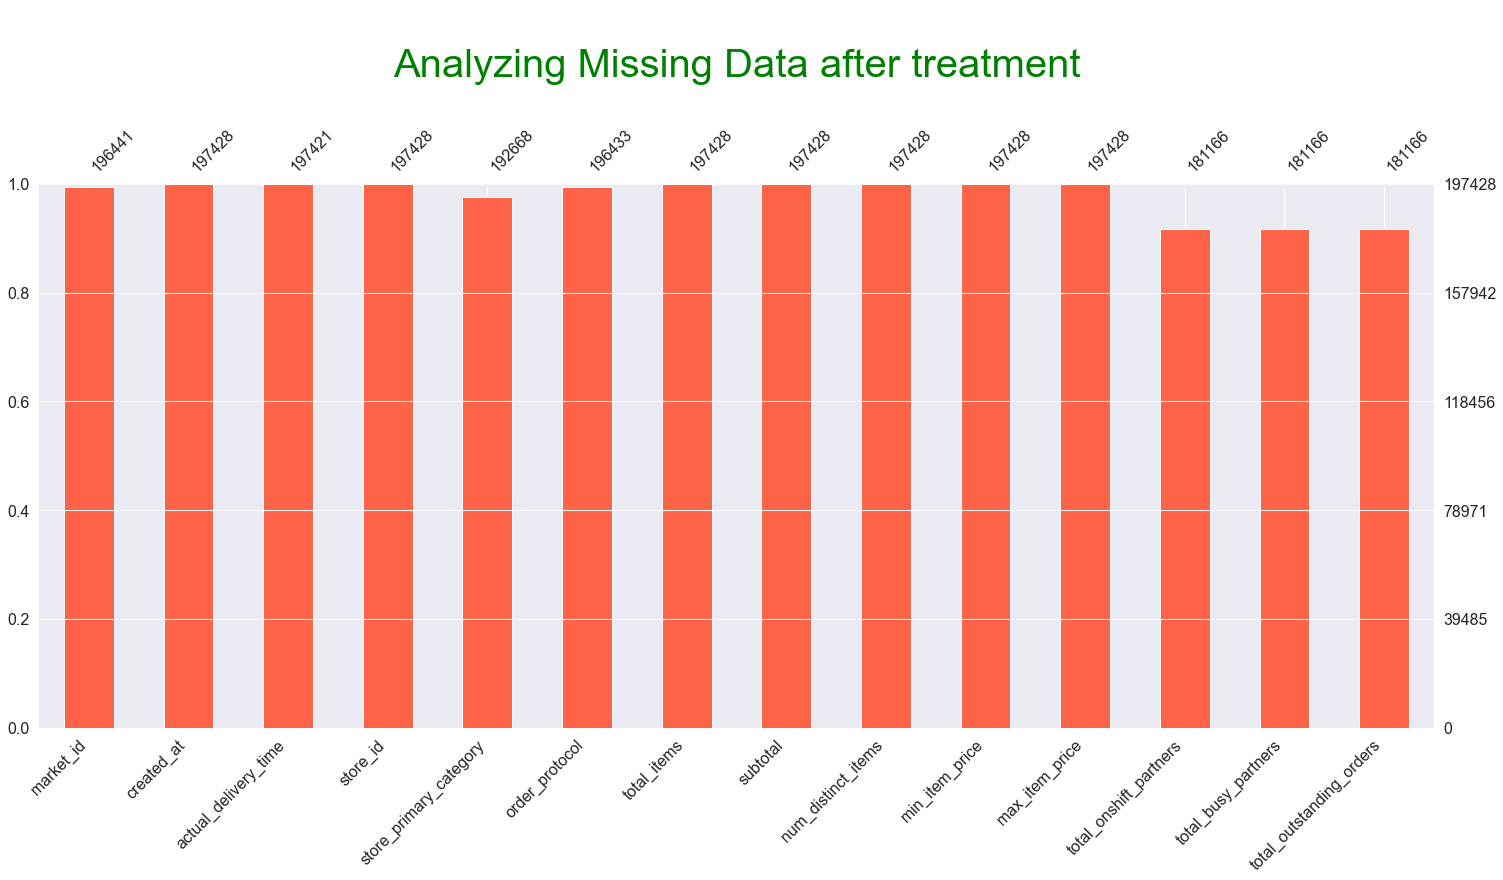

In [120]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data after treatment\n", fontsize=40, color="green")
plt.show()

***
***
### **Dropping records which don't have delivery time details as we won't have target/label for these records**

In [121]:
df = df.drop(df[df.actual_delivery_time.isna()].index)

***
***
### **Filling missing records in 'store_primary_category' column with value 'other'**

In [122]:
df.store_primary_category.unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

In [123]:
df.store_primary_category = df.store_primary_category.fillna('other')

***
***
### **Filling missing records in 'market_id' column with the most frequent value**

In [125]:
df.market_id.unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [126]:
df.market_id.value_counts()

2.0    55055
4.0    47597
1.0    38037
3.0    23296
5.0    17999
6.0    14450
Name: market_id, dtype: int64

In [127]:
df.market_id = df.market_id.fillna(2.0)

***
***
### **Filling missing records in 'order_protocol' column with the most frequent value**

In [128]:
df.order_protocol.unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.,  7.])

In [129]:
df.order_protocol.value_counts()

1.0    54723
3.0    53197
5.0    44289
2.0    24051
4.0    19353
6.0      794
7.0       19
Name: order_protocol, dtype: int64

In [130]:
df.order_protocol = df.order_protocol.fillna(1.0)

***
***
### **Removing records with negative values for 'total_onshift_partners' column**

In [131]:
df.total_onshift_partners.unique()

array([ 33.,   1.,   6.,   2.,  10.,   7.,   8.,   3.,  16.,   5.,   4.,
        24.,  12.,  19.,  21.,  22.,  27.,  13.,  18., 117., 130., 121.,
        94.,  34.,  17.,  38.,  20.,  15.,  39.,  26.,  30.,  35.,  11.,
        14.,  32.,  29.,  25.,  23.,  61.,  41.,  58.,  51.,  57.,  60.,
         9., 108.,  72.,  89., 112.,  55., 126.,  80.,  69., 125., 113.,
       105.,  98.,  86.,  90.,  87.,  74.,  84.,  91.,  96., 123., 101.,
       119.,  nan, 129.,  66.,  81.,  36.,  75.,  43.,  70.,  65.,  77.,
       114.,  62., 116., 102.,  76.,  67.,  64.,  88.,  73.,  63.,  46.,
        28.,  47., 110.,  97.,  42.,  79.,  49.,  50.,  37.,  92., 103.,
        44.,  68.,  56.,   0., 107.,  78.,  71., 128., 104.,  45.,  31.,
       100.,  40.,  53., 115., 109.,  99.,  85.,  59., 118.,  54.,  52.,
        48., 132., 127., 133., 131., 149.,  93., 111.,  95.,  82., 136.,
       120., 134., 124., 106., 137.,  83., 152., 147., 144., 150., 145.,
       122., 155., 135., 151., 140., 141., 143., 13

In [132]:
df[df.total_onshift_partners <= 0].total_onshift_partners.value_counts()

 0.0    3615
-2.0      13
-1.0       6
-3.0       1
-4.0       1
Name: total_onshift_partners, dtype: int64

In [133]:
df = df.drop(df[df.total_onshift_partners < 0].index)

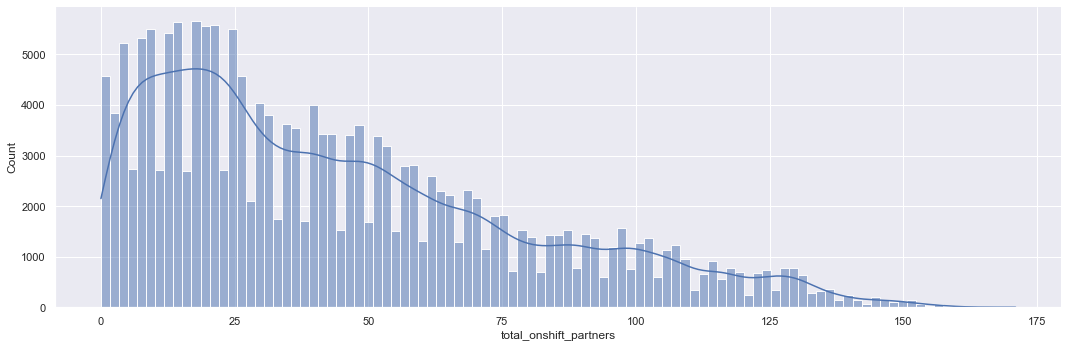

In [134]:
sns.displot(df.total_onshift_partners, kde=True, height=5, aspect=3);

***
***
### **Removing records with negative values for 'total_busy_partners' column**

In [135]:
df.total_busy_partners.unique()

array([ 14.,   2.,   0.,   1.,   6.,   9.,   8.,   3.,   5.,   4.,  24.,
        13.,  19.,  17.,  11.,  21.,  25.,  16.,  18.,  12., 112., 129.,
       119.,  92.,  30.,  15.,  33.,  22.,  37.,  29.,  23.,  31.,  34.,
        20.,  62.,  28.,  44.,  39.,  32.,  53.,  52.,  59.,  57.,   7.,
        10., 100.,  72.,  81., 106.,  84., 122., 109.,  54.,  89., 103.,
        91.,  83.,  75., 107., 102.,  38.,  96.,  80.,  94.,  64., 117.,
       125., 110.,  nan, 128.,  27.,  35.,  70.,  74.,  60.,  73.,  40.,
        97.,  77.,  61.,  58., 116., 123.,  42.,  26.,  95.,  68., 108.,
        55.,  78.,  67.,  69.,  99.,  45.,  63.,  71.,  50.,  48.,  41.,
        66., 127.,  79.,  85.,  88.,  98., 118.,  90.,  36., 121.,  65.,
        47.,  49.,  43.,  46.,  93., 132., 104., 114., 124.,  56.,  51.,
        76., 101., 130.,  86., 138., 136.,  82.,  87., 143., 120., 146.,
       131., 113., 115., 148., 105., 126., 141., 111., 135., 137., 153.,
       133.,  -1., 145., 139., 134., 142., 150., 14

In [136]:
df[df.total_busy_partners <= 0].total_busy_partners.value_counts()

 0.0    4170
-1.0      12
-2.0       3
-3.0       2
-4.0       2
-5.0       1
Name: total_busy_partners, dtype: int64

In [137]:
df = df.drop(df[df.total_busy_partners < 0].index)

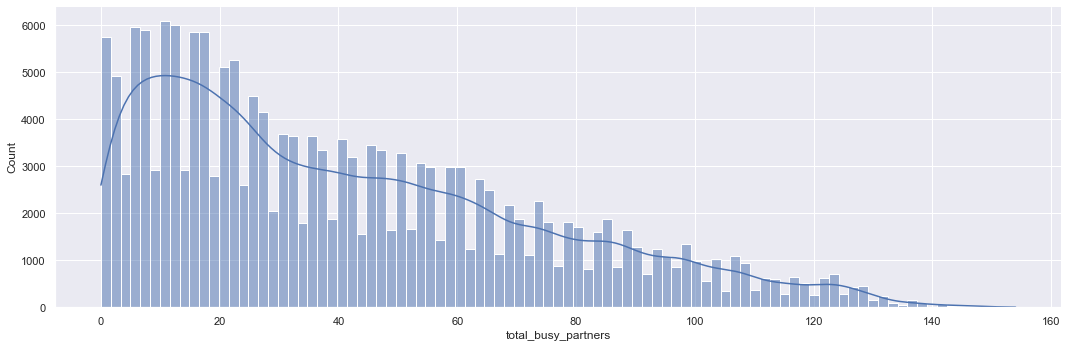

In [138]:
sns.displot(df.total_busy_partners, kde=True, height=5, aspect=3);

***
***
### **Removing records with negative values for 'total_outstanding_orders' column**

In [139]:
df.total_outstanding_orders.unique()

array([ 21.,   2.,   0.,   9.,   7.,  18.,   1.,   4.,   3.,   8.,  12.,
        26.,  11.,  30.,  16.,  39.,  24.,  27.,  20.,  13., 178., 230.,
       205., 149.,  28.,  15.,  42.,  43.,  33.,   5.,  37.,  46.,  36.,
        14.,  29.,  32.,  72.,  41.,  54.,  49.,  23.,  56.,  60.,  10.,
         6., 154., 144.,  34., 100., 173.,  80., 202., 124., 130., 181.,
       188., 148., 150., 127., 160., 107., 123., 159., 186., 143., 190.,
       171.,  nan, 261., 132.,  67., 120., 158.,  59.,  38.,  47.,  68.,
        92.,  99., 175., 102., 184., 121.,  17.,  96., 111.,  22., 131.,
       141.,  89.,  48.,  65., 194.,  73.,  45., 203., 134., 126., 183.,
        64., 167.,  31., 153., 119.,  75.,  95.,  52., 118., 191.,  61.,
       106.,  19.,  58., 152., 101.,  35., 151.,  83., 179.,  97.,  44.,
        25., 147., 169., 135., 142., 165., 172.,  91.,  40., 237., 198.,
       220., 219.,  78.,  90., 138., 168.,  85.,  81., 212., 192., 137.,
       189.,  51.,  74.,  62.,  63.,  50., 122.,  9

In [140]:
df[df.total_outstanding_orders <= 0].total_outstanding_orders.value_counts()

 0.0    4110
-1.0      15
-3.0       7
-2.0       6
-6.0       5
-5.0       5
-4.0       2
Name: total_outstanding_orders, dtype: int64

In [141]:
df = df.drop(df[df.total_outstanding_orders < 0].index)

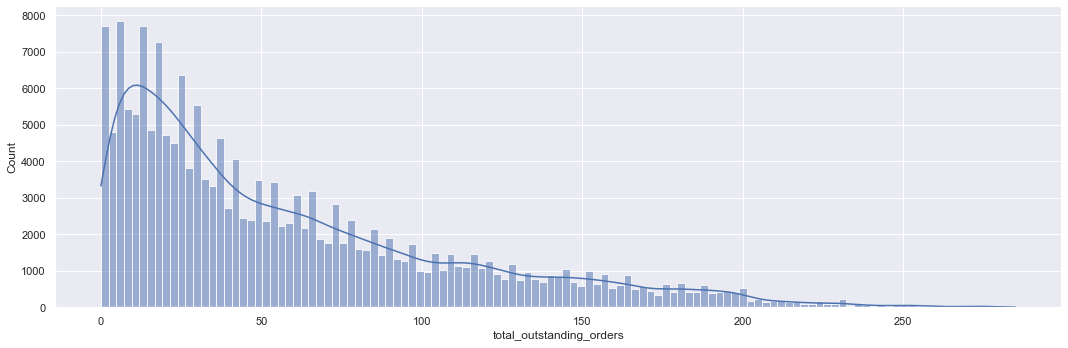

In [142]:
sns.displot(df.total_outstanding_orders, kde=True, height=5, aspect=3);

***
***
### **Removing records with missing values for 'total_onshift_partners', 'total_busy_partners' or 'total_outstanding_orders' columns, as imputing them with a single value would disrupt their distributions significantly. Considering huge size of the data, using KNN imputer is not feasible.**

In [143]:
df = df.drop(df[df.total_onshift_partners.isna()].index)
df = df.drop(df[df.total_busy_partners.isna()].index)
df = df.drop(df[df.total_outstanding_orders.isna()].index)

In [144]:
df = convert_to_best_type(df)
df['time_taken_to_deliver'] = np.round((df.actual_delivery_time-df.created_at).dt.total_seconds()/12, 2)
df['order_placed_day_of_week'] = df.created_at.dt.dayofweek
df['order_placed_hour_of_day'] = df.created_at.dt.hour
df = convert_to_best_type(df)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181078 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 181078 non-null  category      
 1   created_at                181078 non-null  datetime64[ns]
 2   actual_delivery_time      181078 non-null  datetime64[ns]
 3   store_id                  181078 non-null  string        
 4   store_primary_category    181078 non-null  string        
 5   order_protocol            181078 non-null  category      
 6   total_items               181078 non-null  int64         
 7   subtotal                  181078 non-null  int64         
 8   num_distinct_items        181078 non-null  int64         
 9   min_item_price            181078 non-null  int64         
 10  max_item_price            181078 non-null  int64         
 11  total_onshift_partners    181078 non-null  float64       
 12  to

***
***
## **3. Univariate Analysis - Categorical Data**

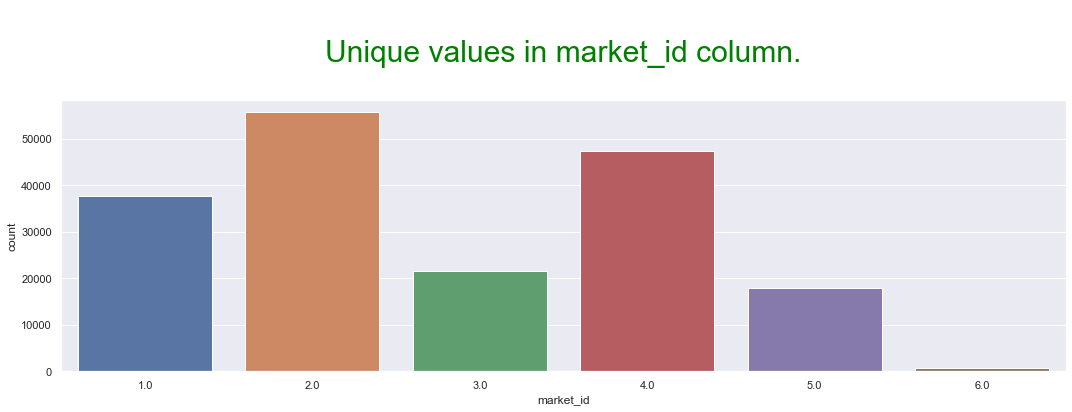

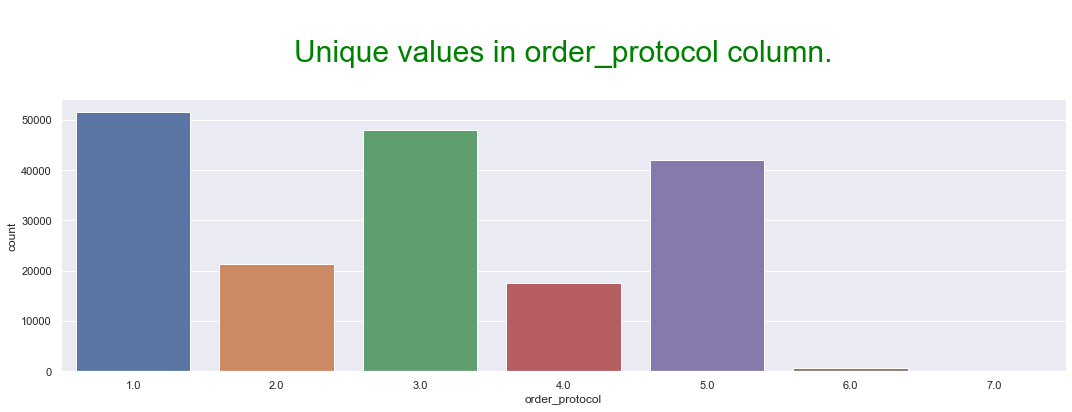

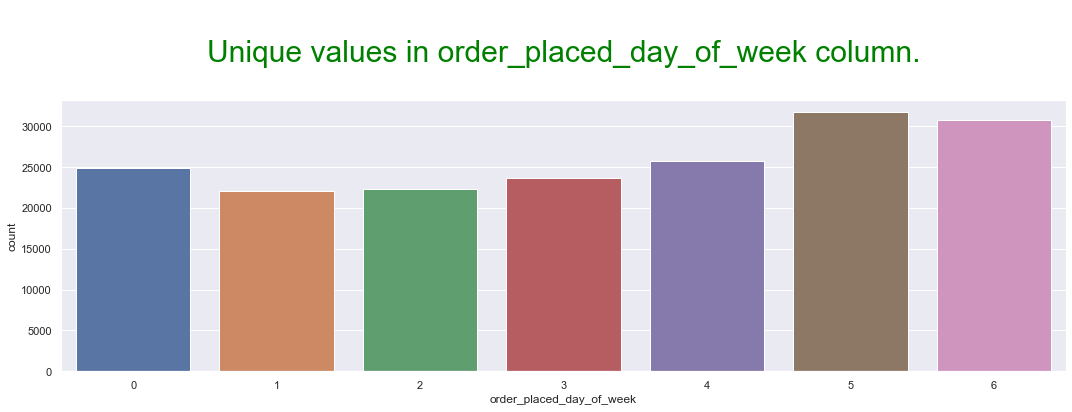

In [146]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **4. Univariate Analysis - Discrete Data**

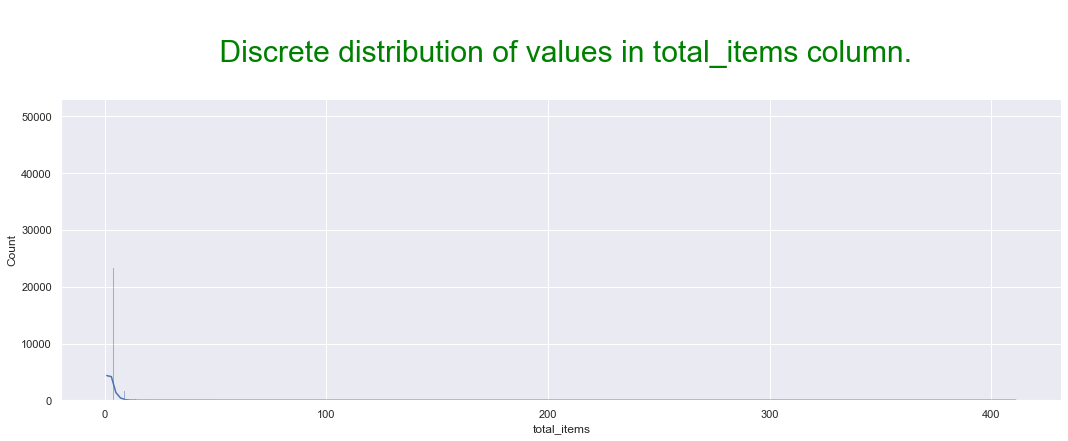

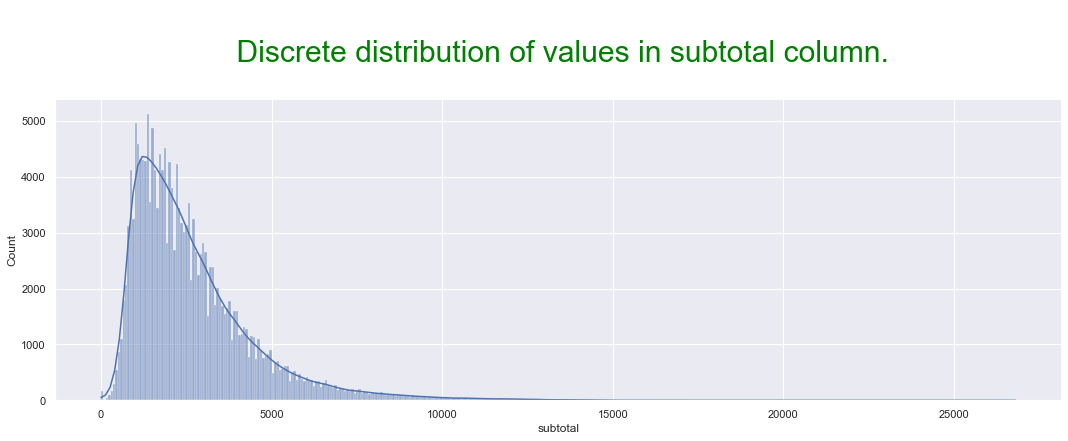

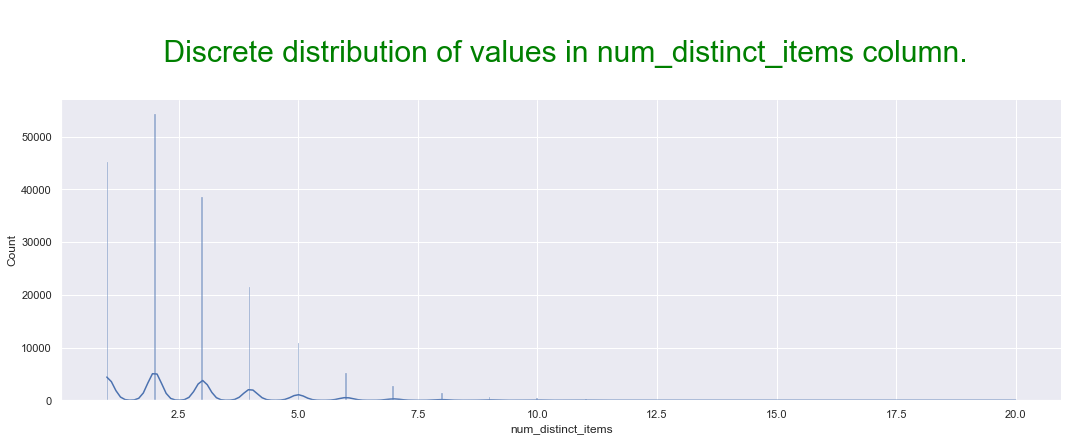

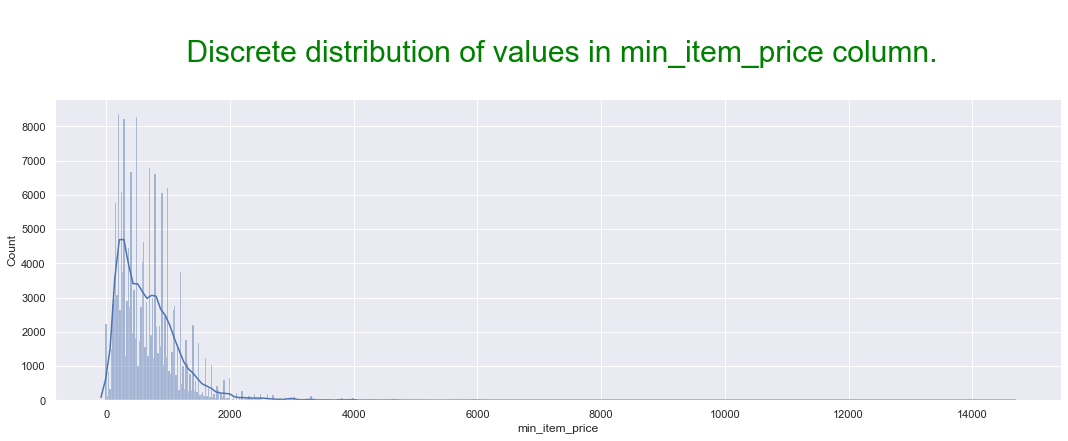

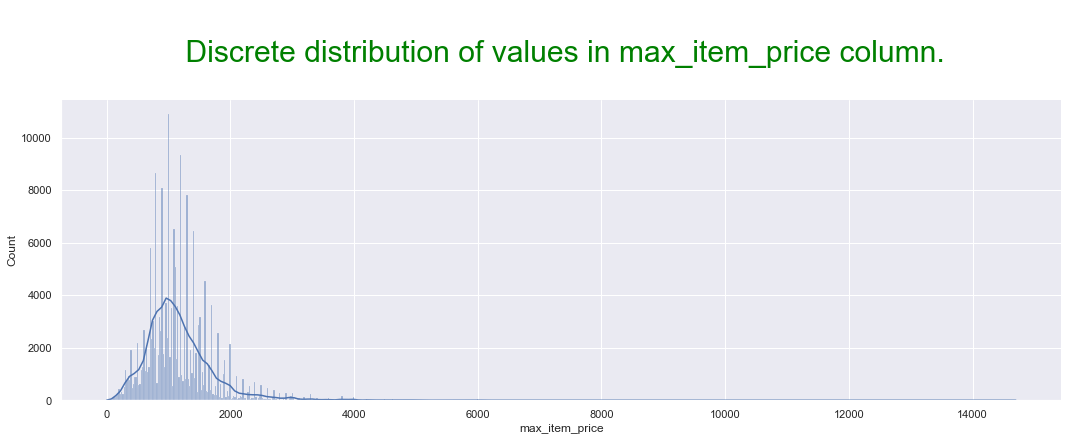

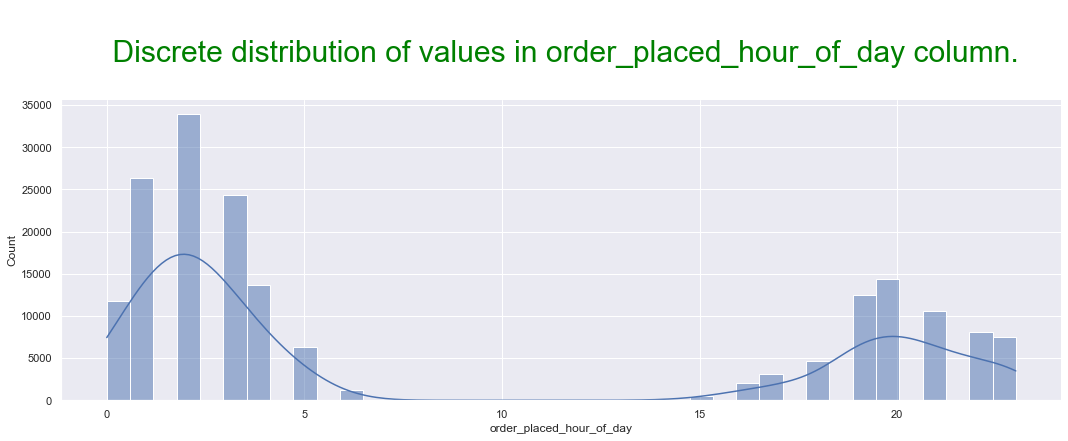

In [147]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
### **Removing outliers manually from 'total_items' column.**

In [148]:
df.total_items.value_counts()

2      50426
1      36642
3      36229
4      23320
5      13022
6       8006
7       4653
8       2802
9       1717
10      1170
11       762
12       607
13       366
14       300
15       213
16       171
17       123
18       100
19        63
20        59
21        46
24        35
22        35
25        32
26        30
23        18
28        18
27        16
30        15
29        12
34         8
42         7
35         7
33         6
31         5
40         4
48         4
36         4
32         4
39         3
38         2
41         2
37         2
45         1
47         1
411        1
57         1
59         1
51         1
50         1
56         1
44         1
49         1
64         1
66         1
Name: total_items, dtype: int64

In [149]:
df = df[df.total_items<411]

***
***
### **Performing Univariate Analysis on Discrete Data again**

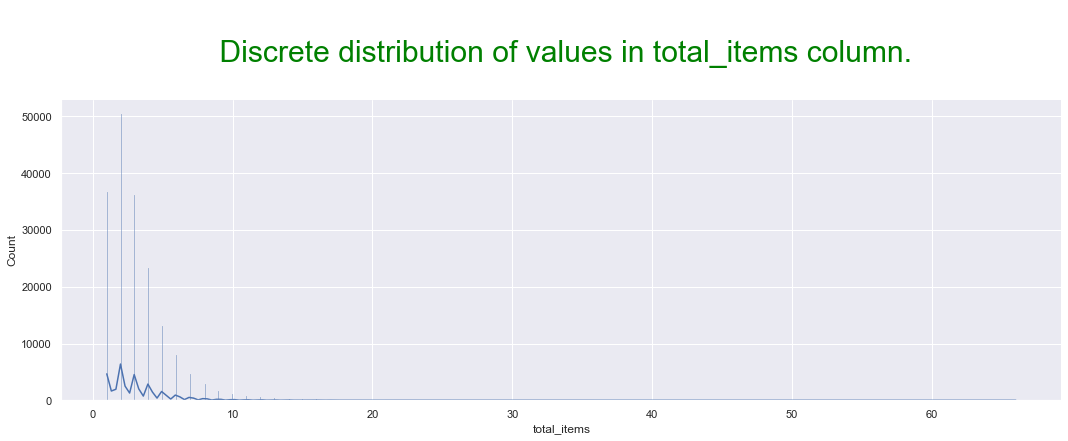

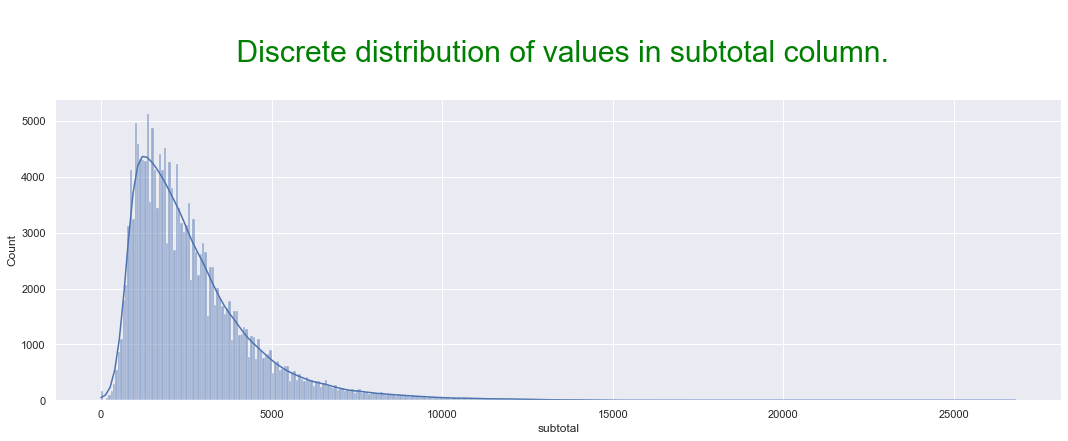

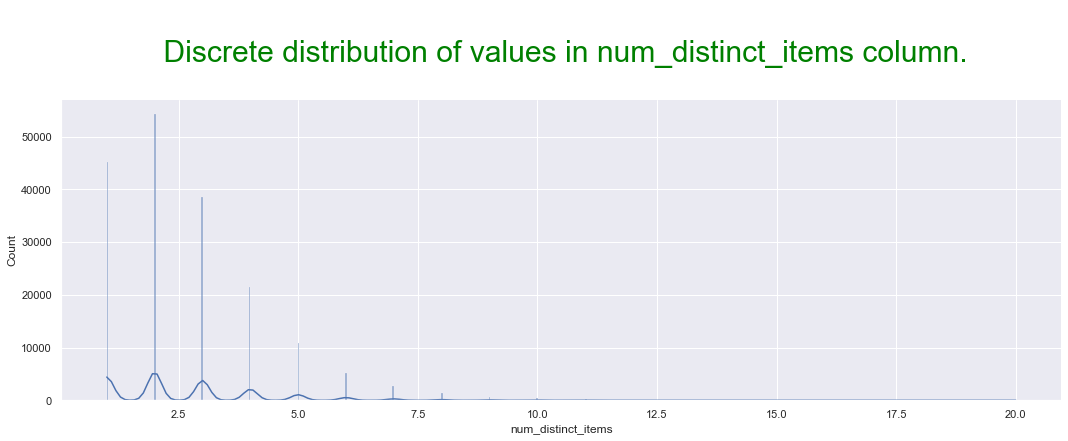

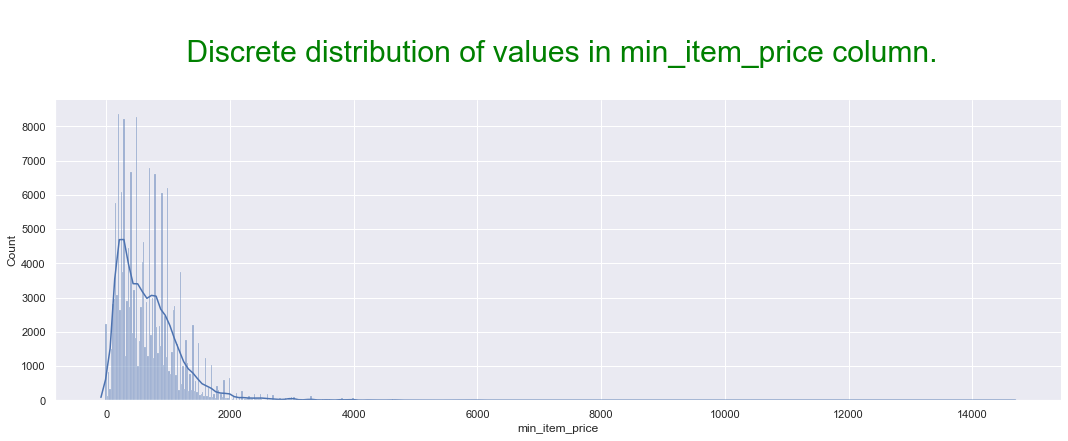

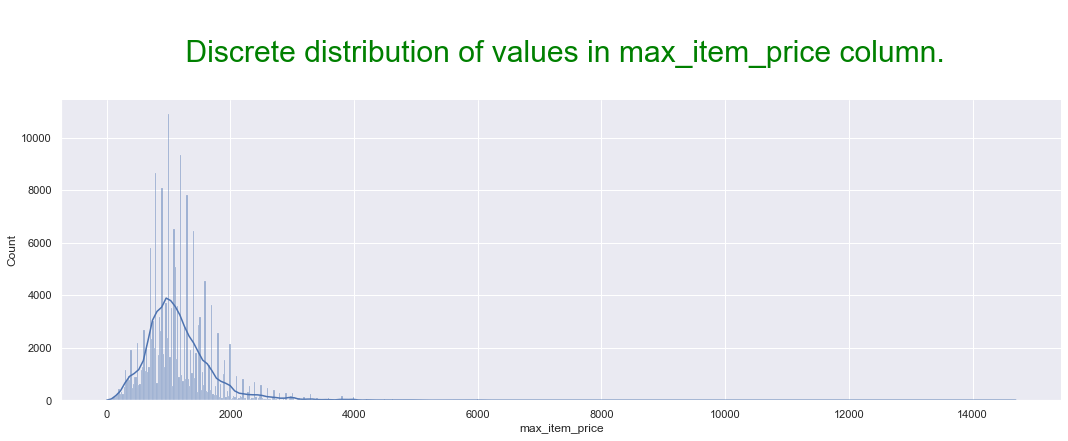

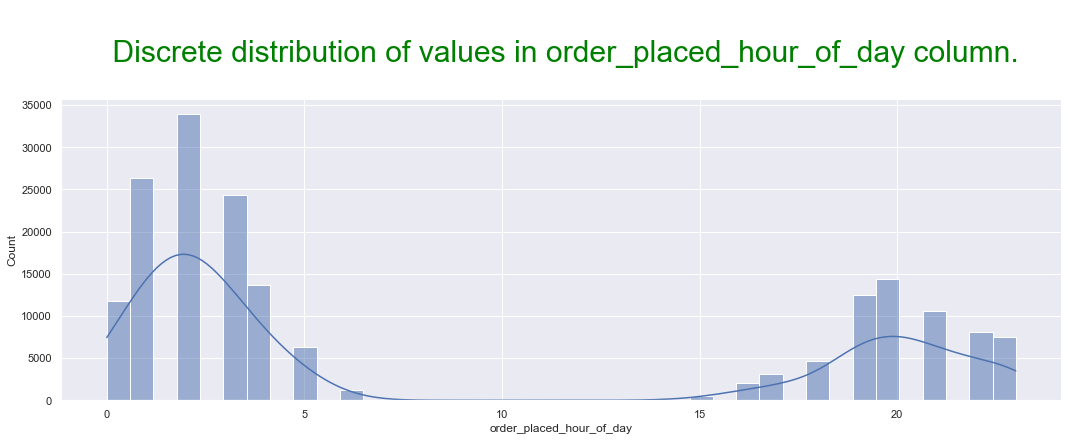

In [150]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **5. Univariate Analysis - Continuous Data**

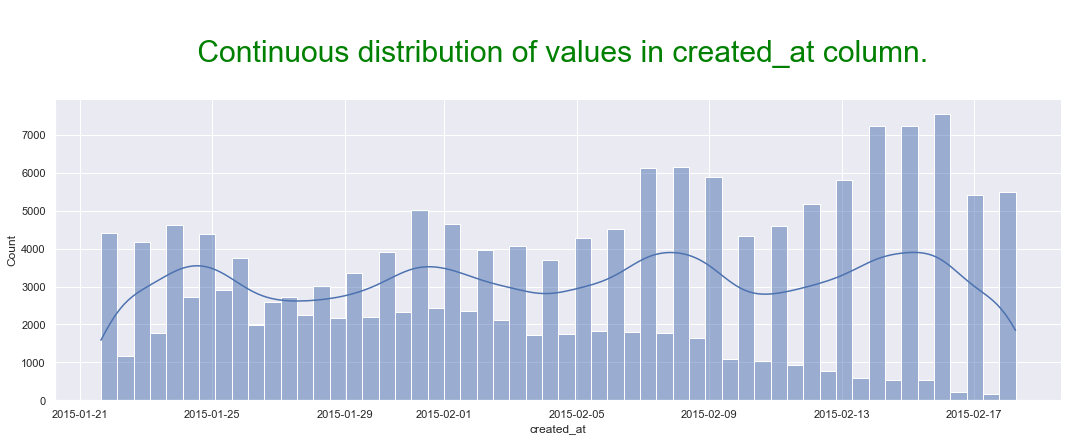

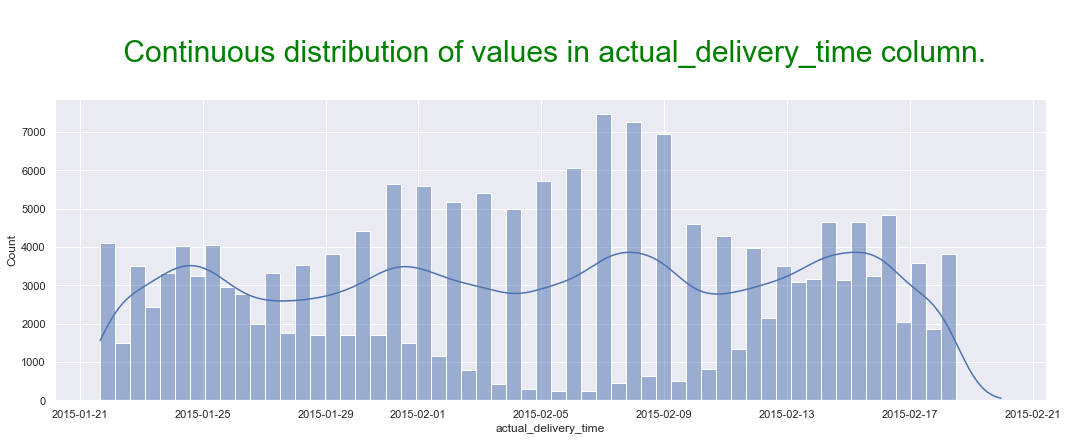

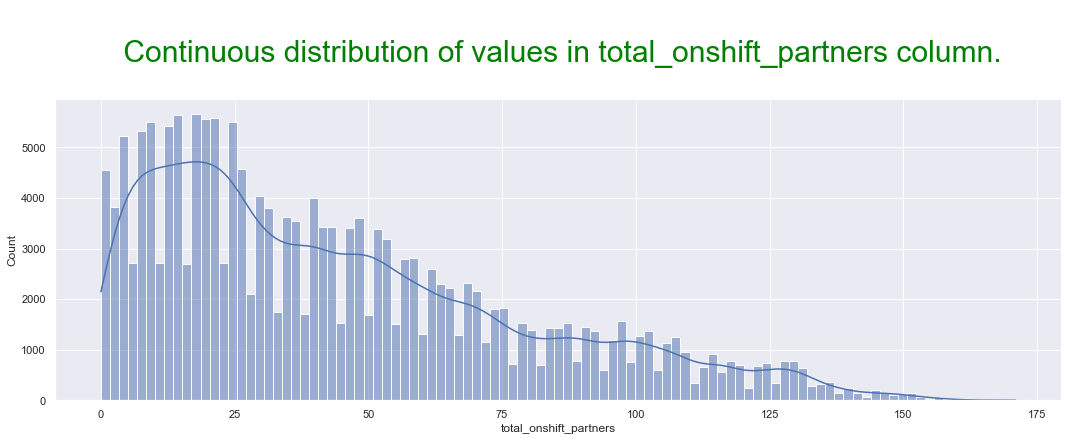

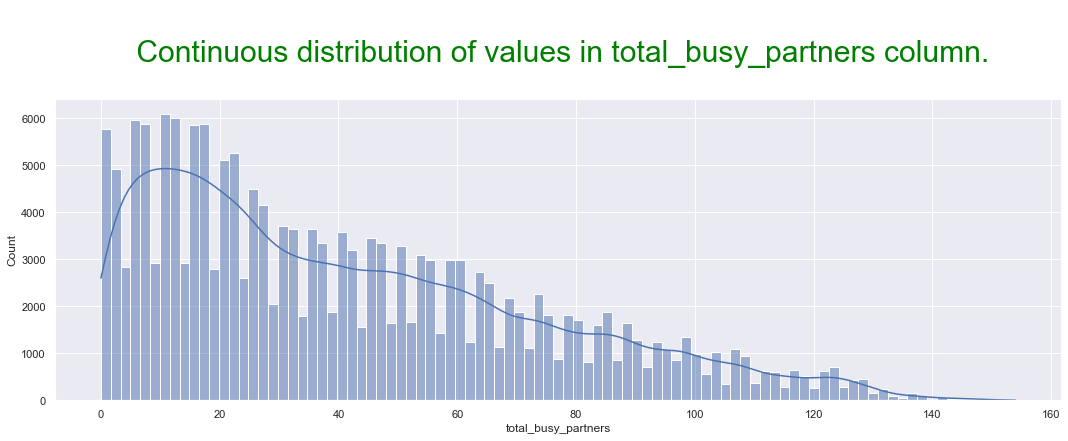

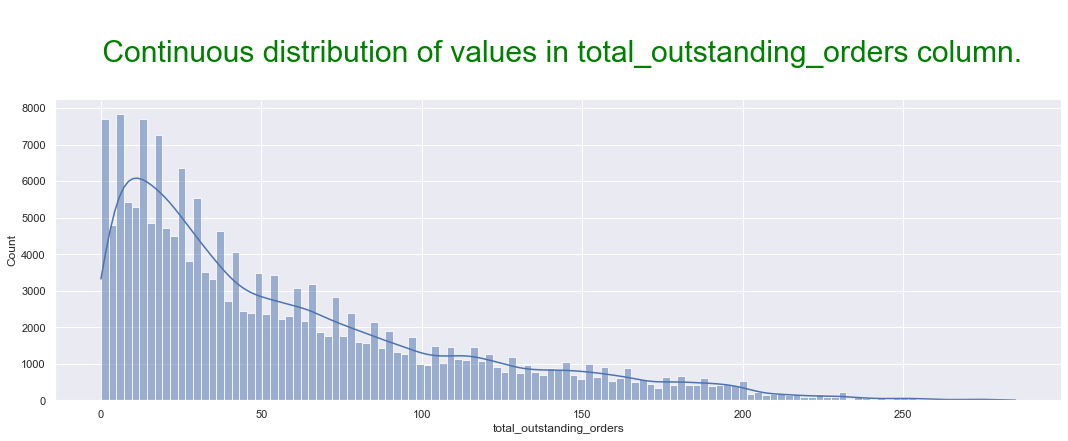

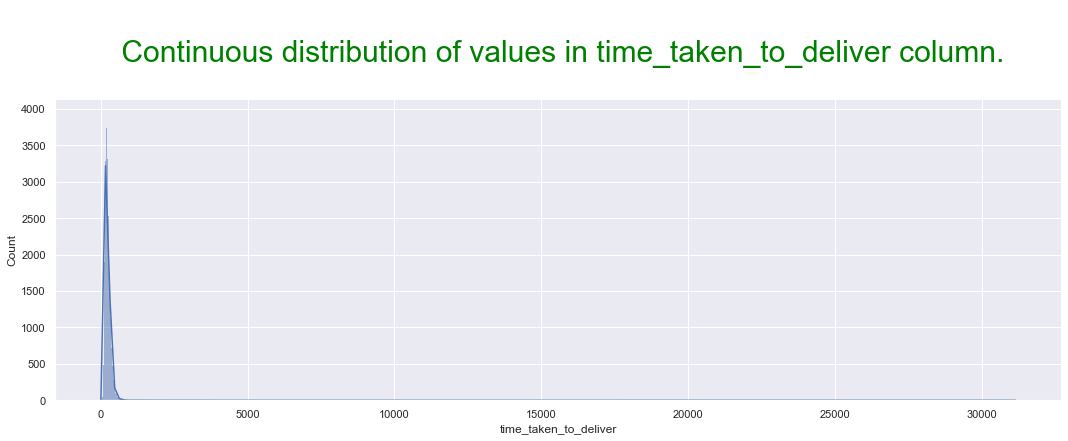

In [151]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Bivariate Analysis**

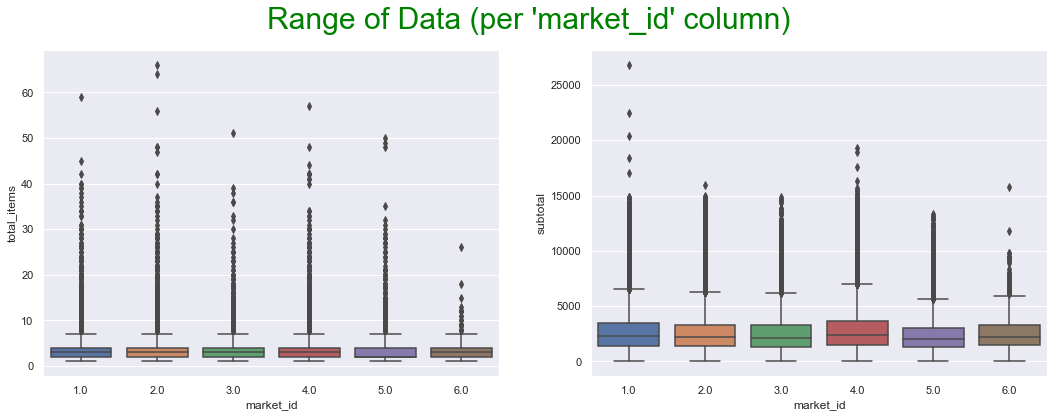

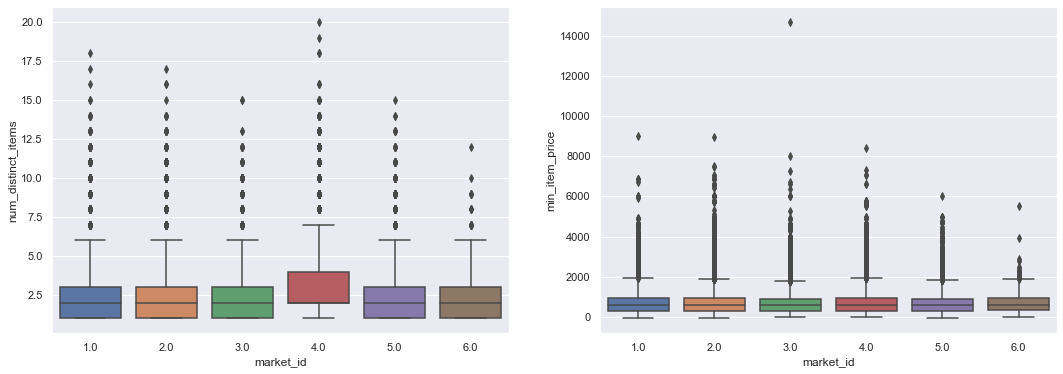

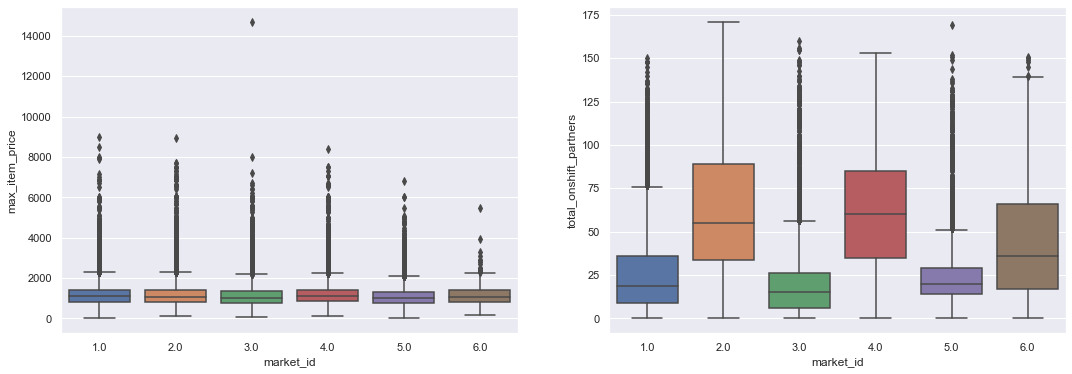

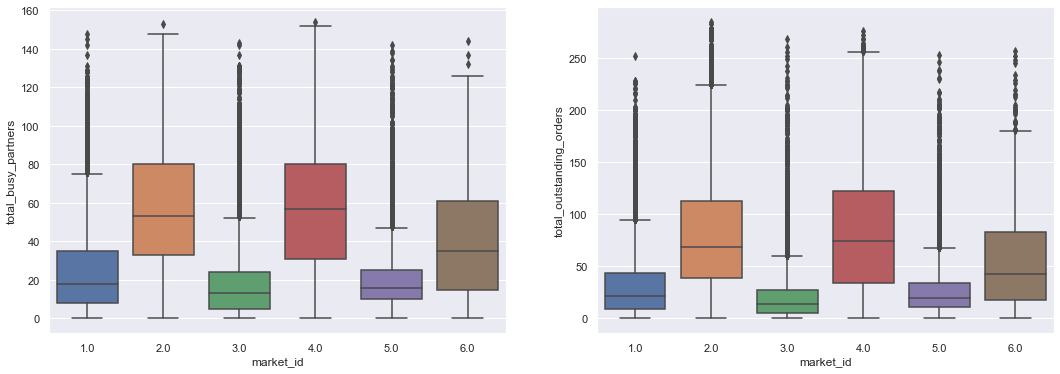

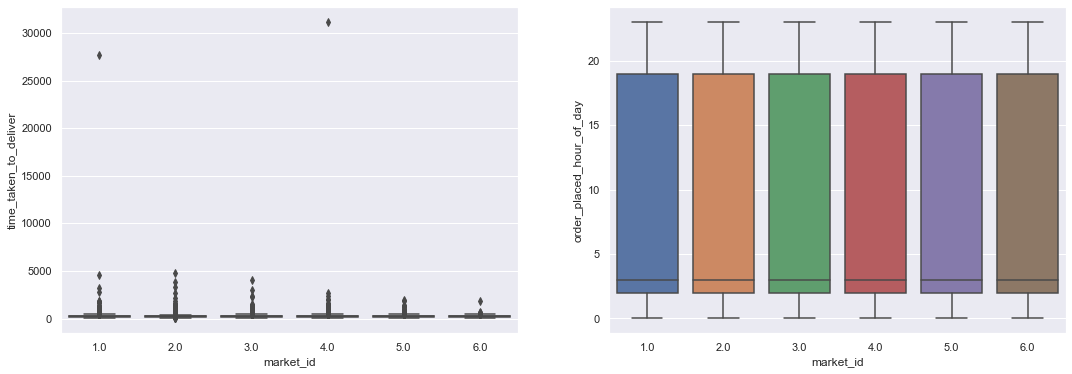

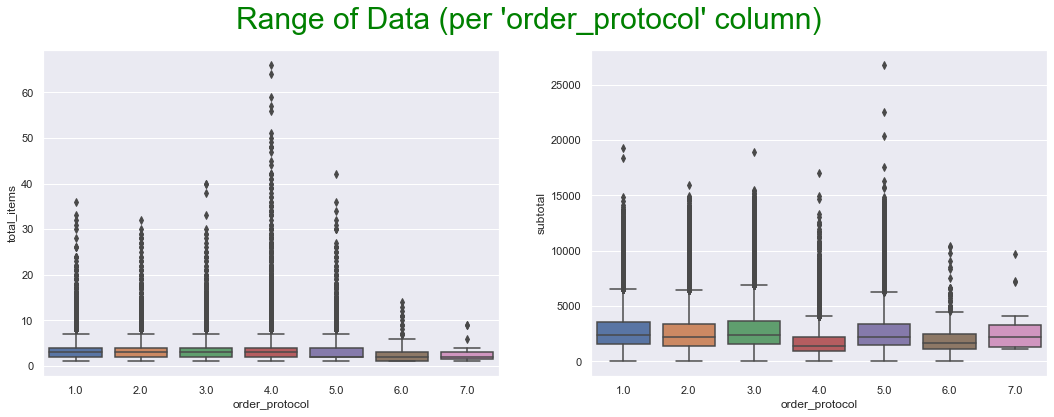

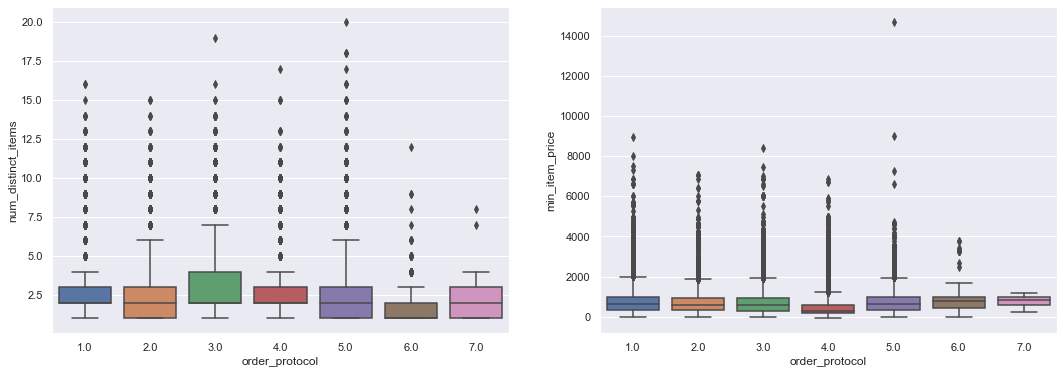

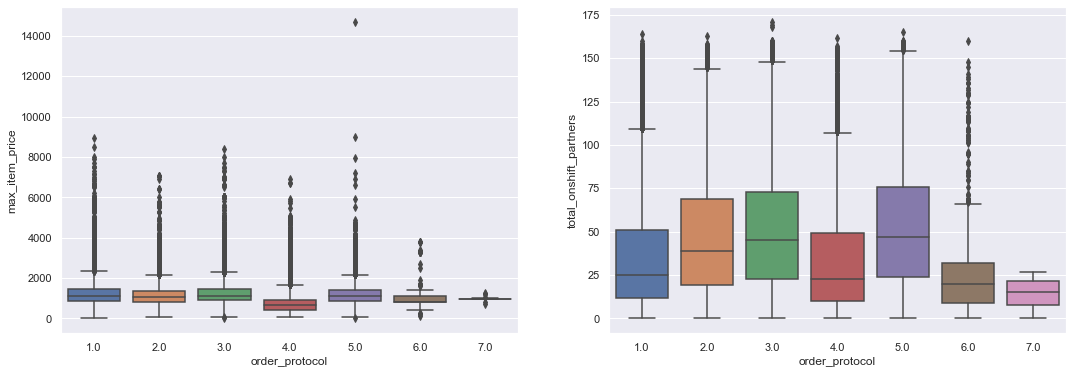

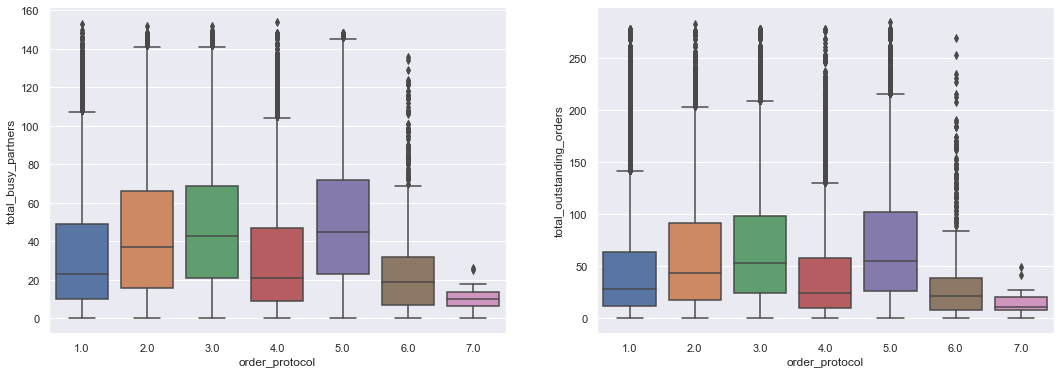

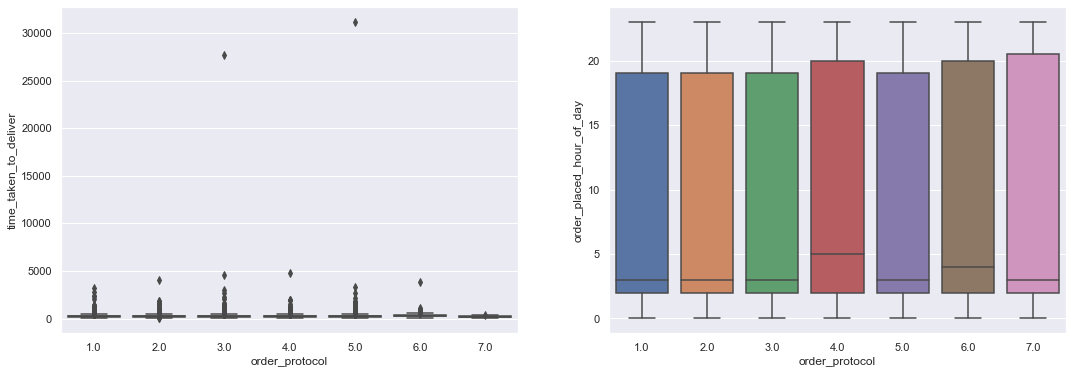

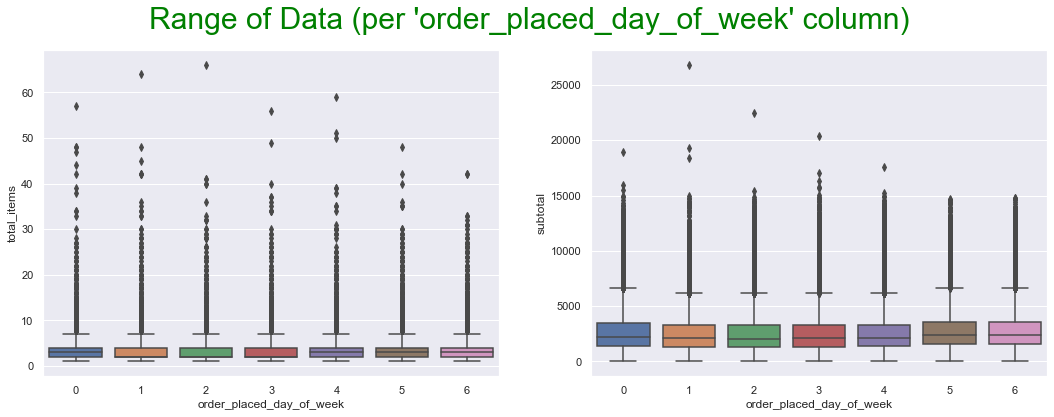

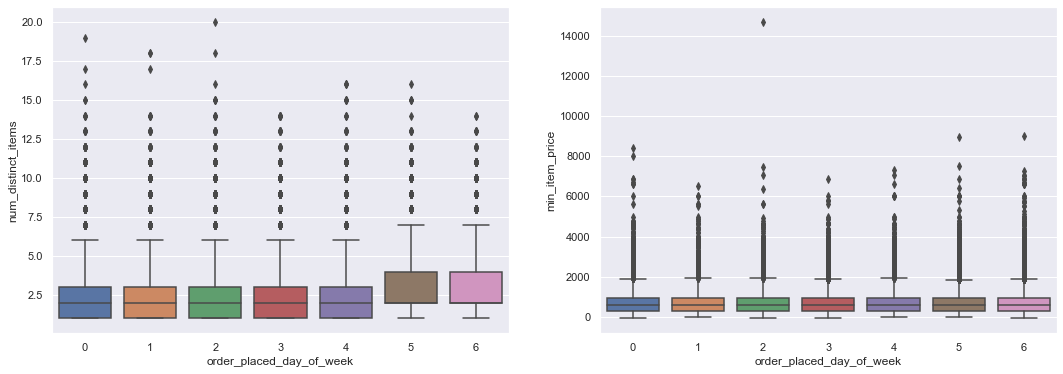

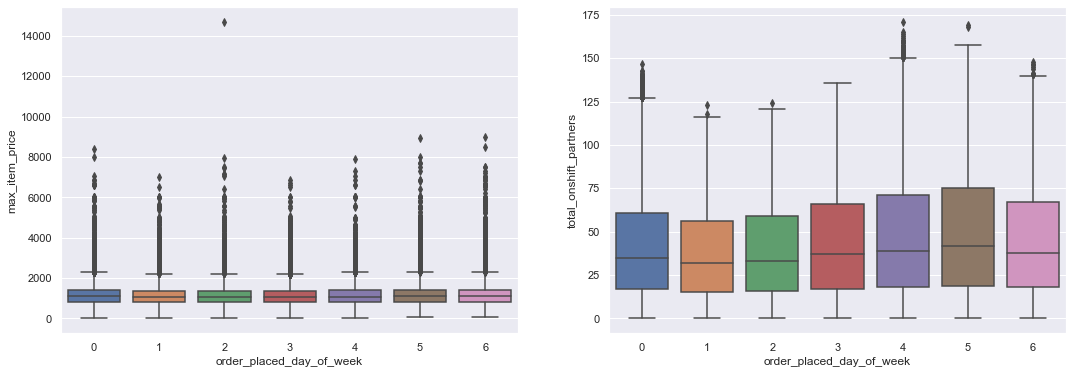

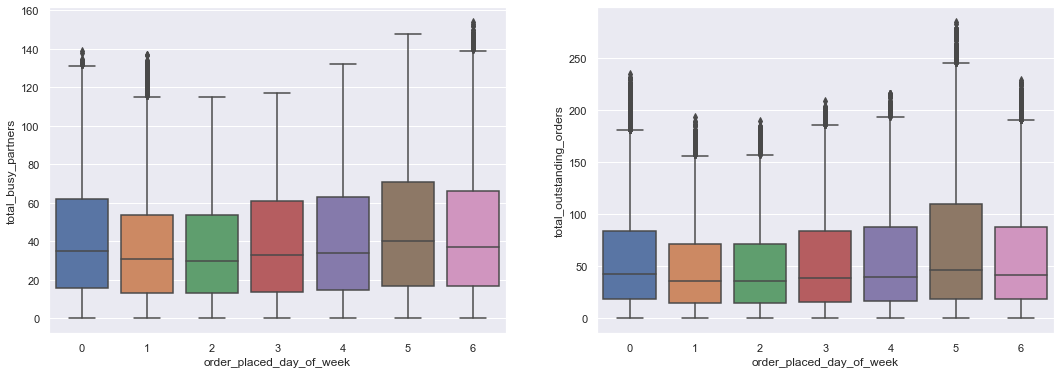

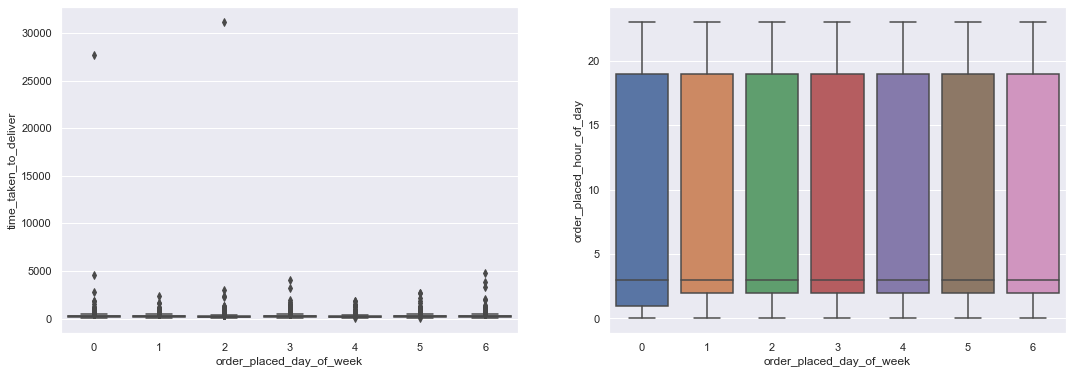

In [152]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

In [153]:
df = df.drop(['actual_delivery_time', 'created_at'], axis=1)

***
***
## **7. Multivariate Analysis**

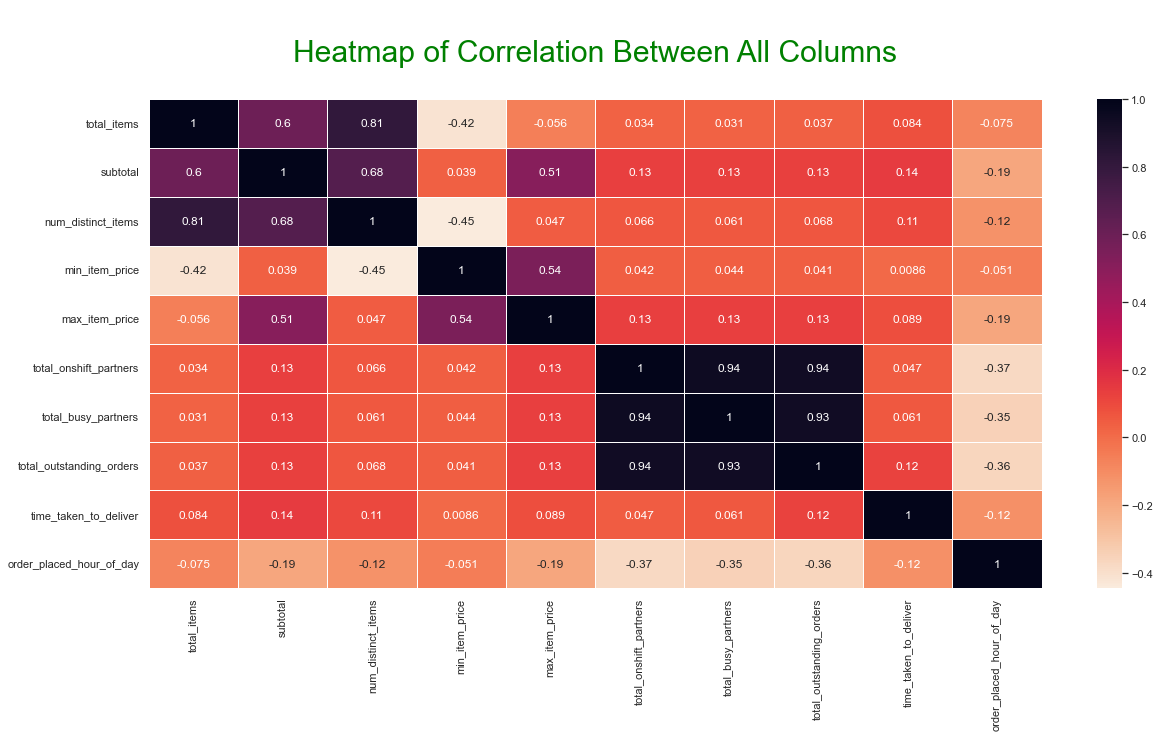

In [154]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

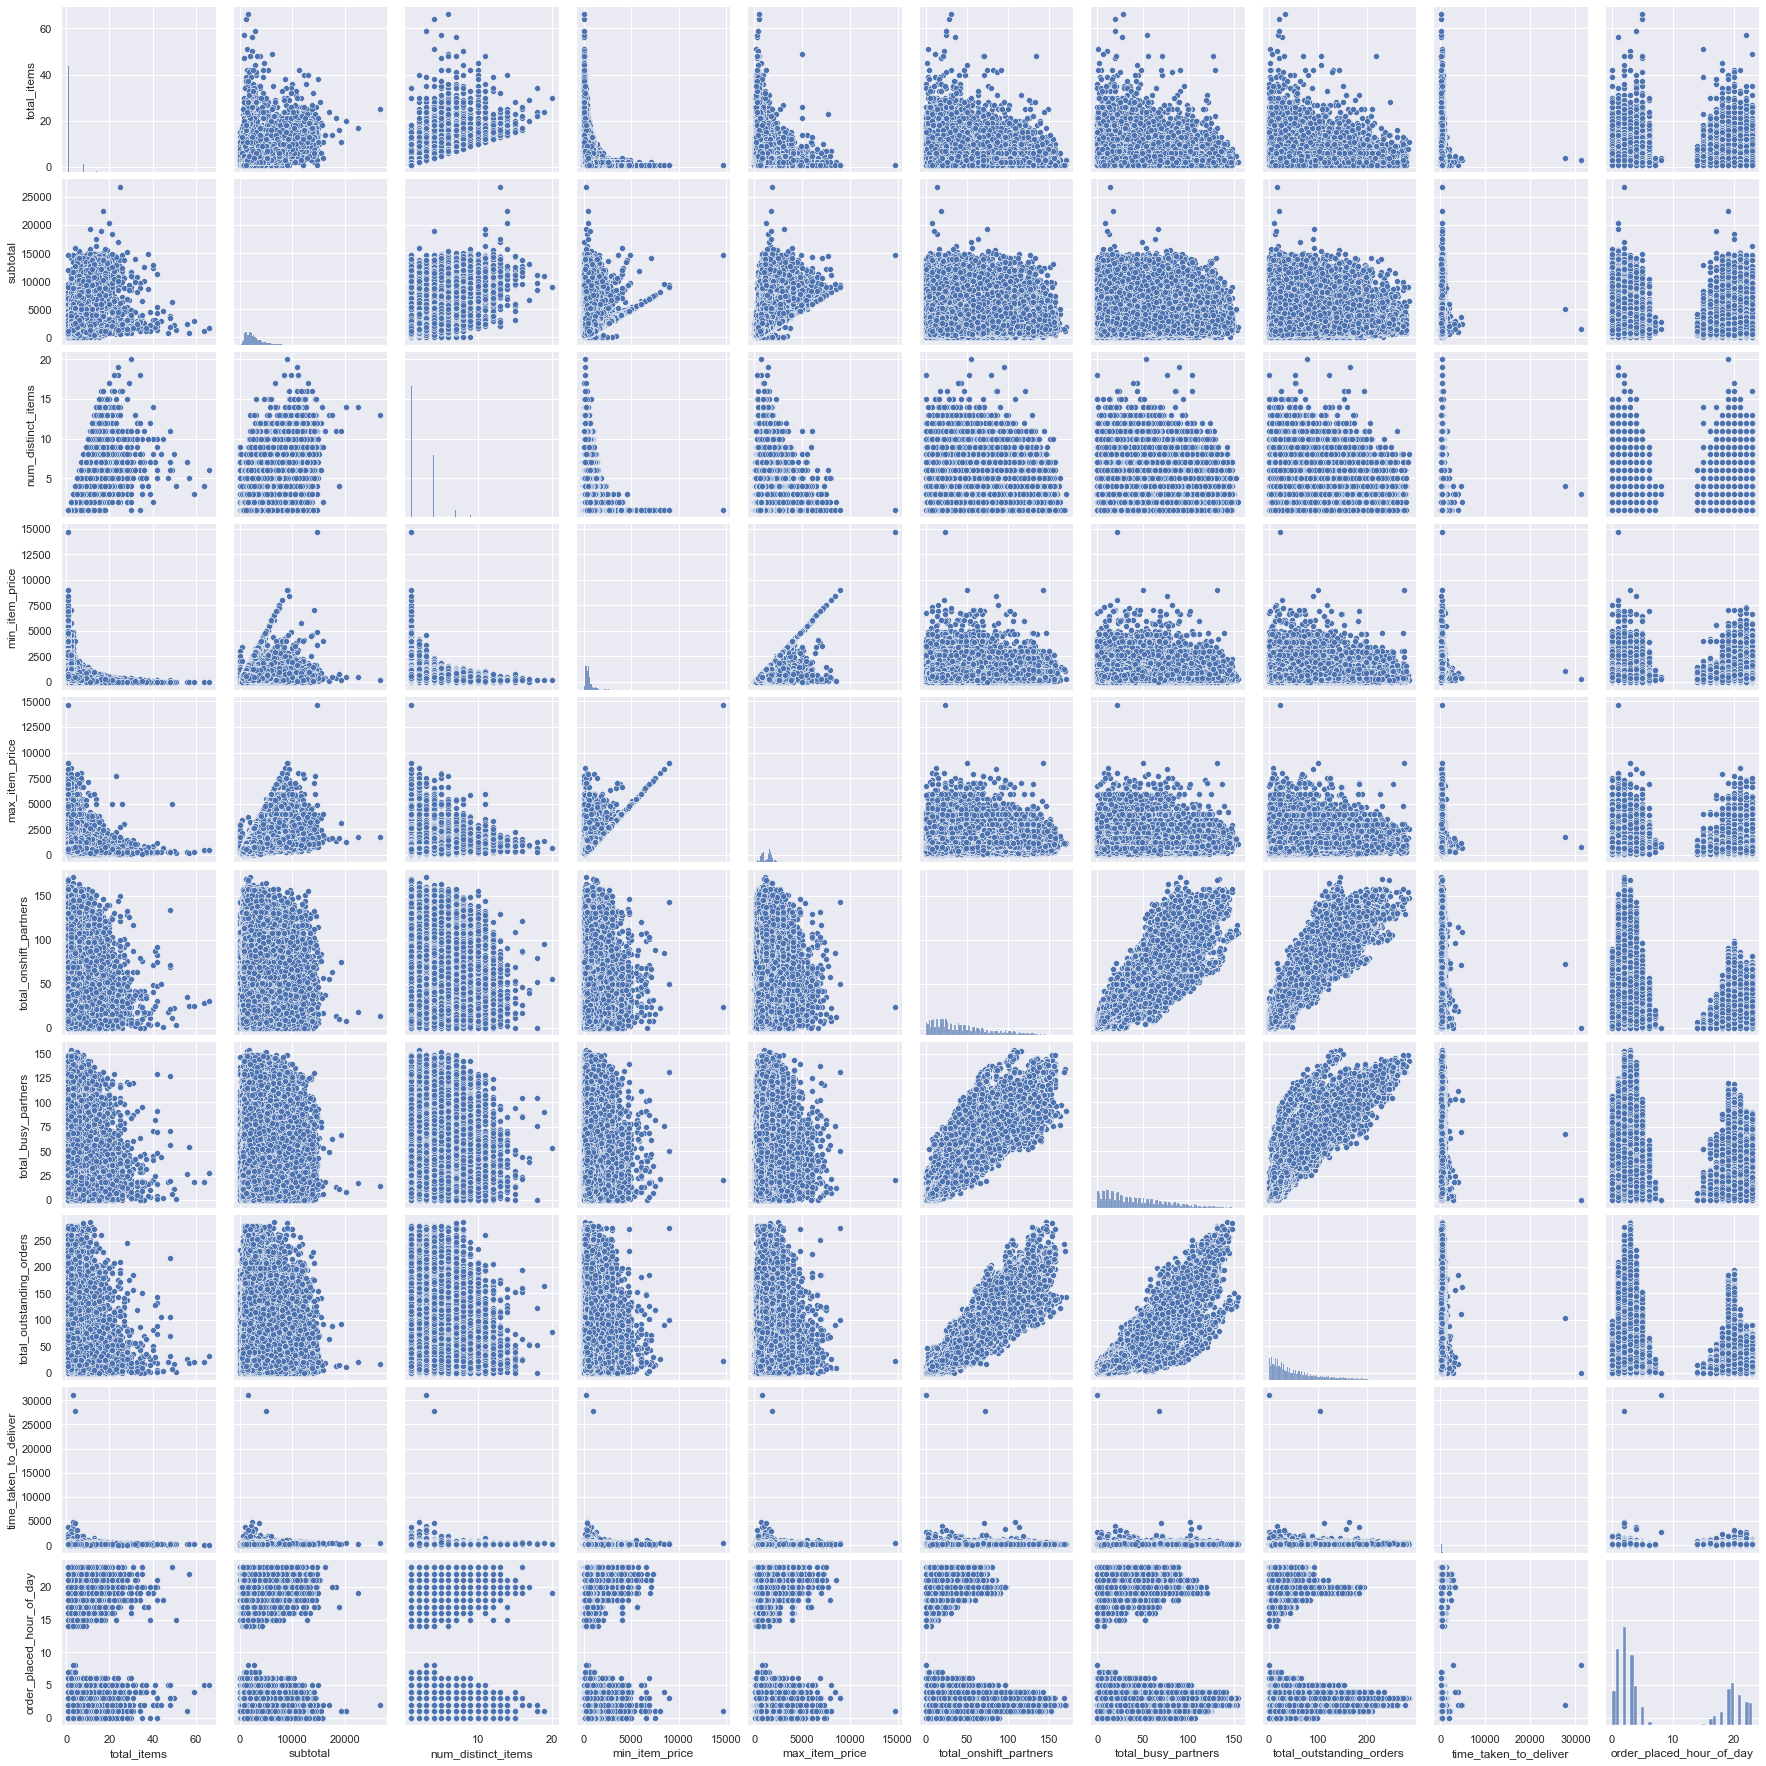

In [155]:
sns.pairplot(df)

In [156]:
df.describe()

total_items       subtotal  num_distinct_items  min_item_price  \
count  181077.000000  181077.000000       181077.000000   181077.000000   
mean        3.206365    2698.583774            2.677745      684.817398   
std         2.495706    1829.406827            1.627297      521.228607   
min         1.000000       0.000000            1.000000      -86.000000   
25%         2.000000    1415.000000            2.000000      299.000000   
50%         3.000000    2225.000000            2.000000      595.000000   
75%         4.000000    3413.000000            3.000000      942.000000   
max        66.000000   26800.000000           20.000000    14700.000000   

       max_item_price  total_onshift_partners  total_busy_partners  \
count   181077.000000           181077.000000        181077.000000   
mean      1160.760781               44.824677            41.755557   
std        561.816395               34.523290            32.142517   
min          0.000000                0.000000             0.000000   
25%        799.000000               17.000000            15.000000   
50%       1095.000000               37.000000            34.000000   
75%       1395.000000               65.000000            62.000000   
max      14700.000000              171.000000           154.000000   

       total_outstanding_orders  time_taken_to_deliver  \
count             181077.000000          181077.000000   
mean                  58.073190             238.851113   
std                   52.658393             137.297591   
min                    0.000000               8.420000   
25%                   17.000000             175.420000   
50%                   41.000000             221.830000   
75%                   85.000000             281.920000   
max                  285.000000           31156.580000   

       order_placed_hour_of_day  
count             181077.000000  
mean                   8.486230  
std                    8.679937  
min                    0.000000  
25%                    2.000000  
50%                    3.000000  
75%                   19.000000  
max                   23.000000

***
***
## **8. Preprocessing Data for Model Training**

In [98]:
filename = 'dataset.csv'
df = pd.read_csv(filename)

In [99]:
df = df.drop(df[df.actual_delivery_time.isna()].index)
df = df.drop(df[df.total_onshift_partners < 0].index)
df = df.drop(df[df.total_busy_partners < 0].index)
df = df.drop(df[df.total_outstanding_orders < 0].index)
df = df.drop(df[df.total_onshift_partners.isna()].index)
df = df.drop(df[df.total_busy_partners.isna()].index)
df = df.drop(df[df.total_outstanding_orders.isna()].index)
df = df[df.total_items<411]
df = convert_to_best_type(df)
df['time_taken_to_deliver'] = np.round((df.actual_delivery_time-df.created_at).dt.total_seconds()/12, 2)
df['order_placed_day_of_week'] = df.created_at.dt.dayofweek
df['order_placed_hour_of_day'] = df.created_at.dt.hour
df = df.drop(['actual_delivery_time', 'created_at'], axis=1)
df = convert_to_best_type(df)
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

***
***
### **Removing Outliers from target as it is extermely skewed**

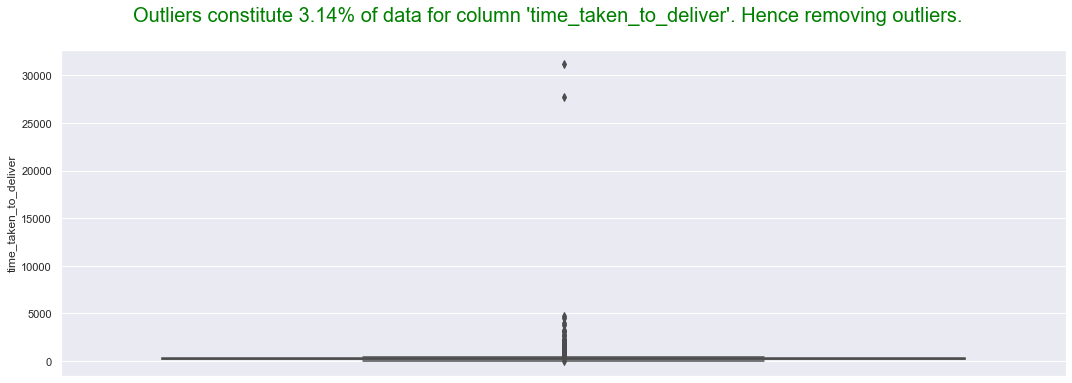

In [33]:
df = remove_outlier(df, 'time_taken_to_deliver', thresh=5)

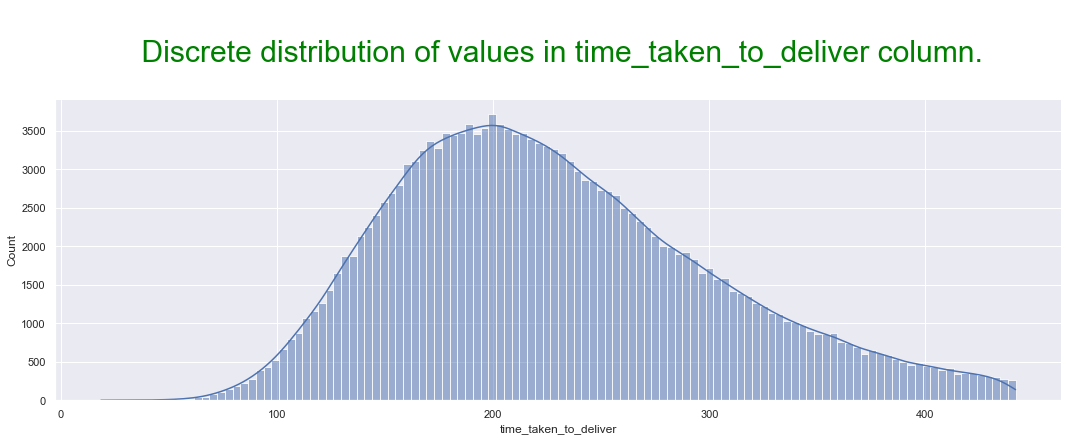

In [34]:
sns.displot(df['time_taken_to_deliver'], kde=True, height=5, aspect=3)
plt.title(f"\n Discrete distribution of values in time_taken_to_deliver column.\n", fontsize=30, color="green")
plt.show()

***
***
### **Multivariate Analysis**

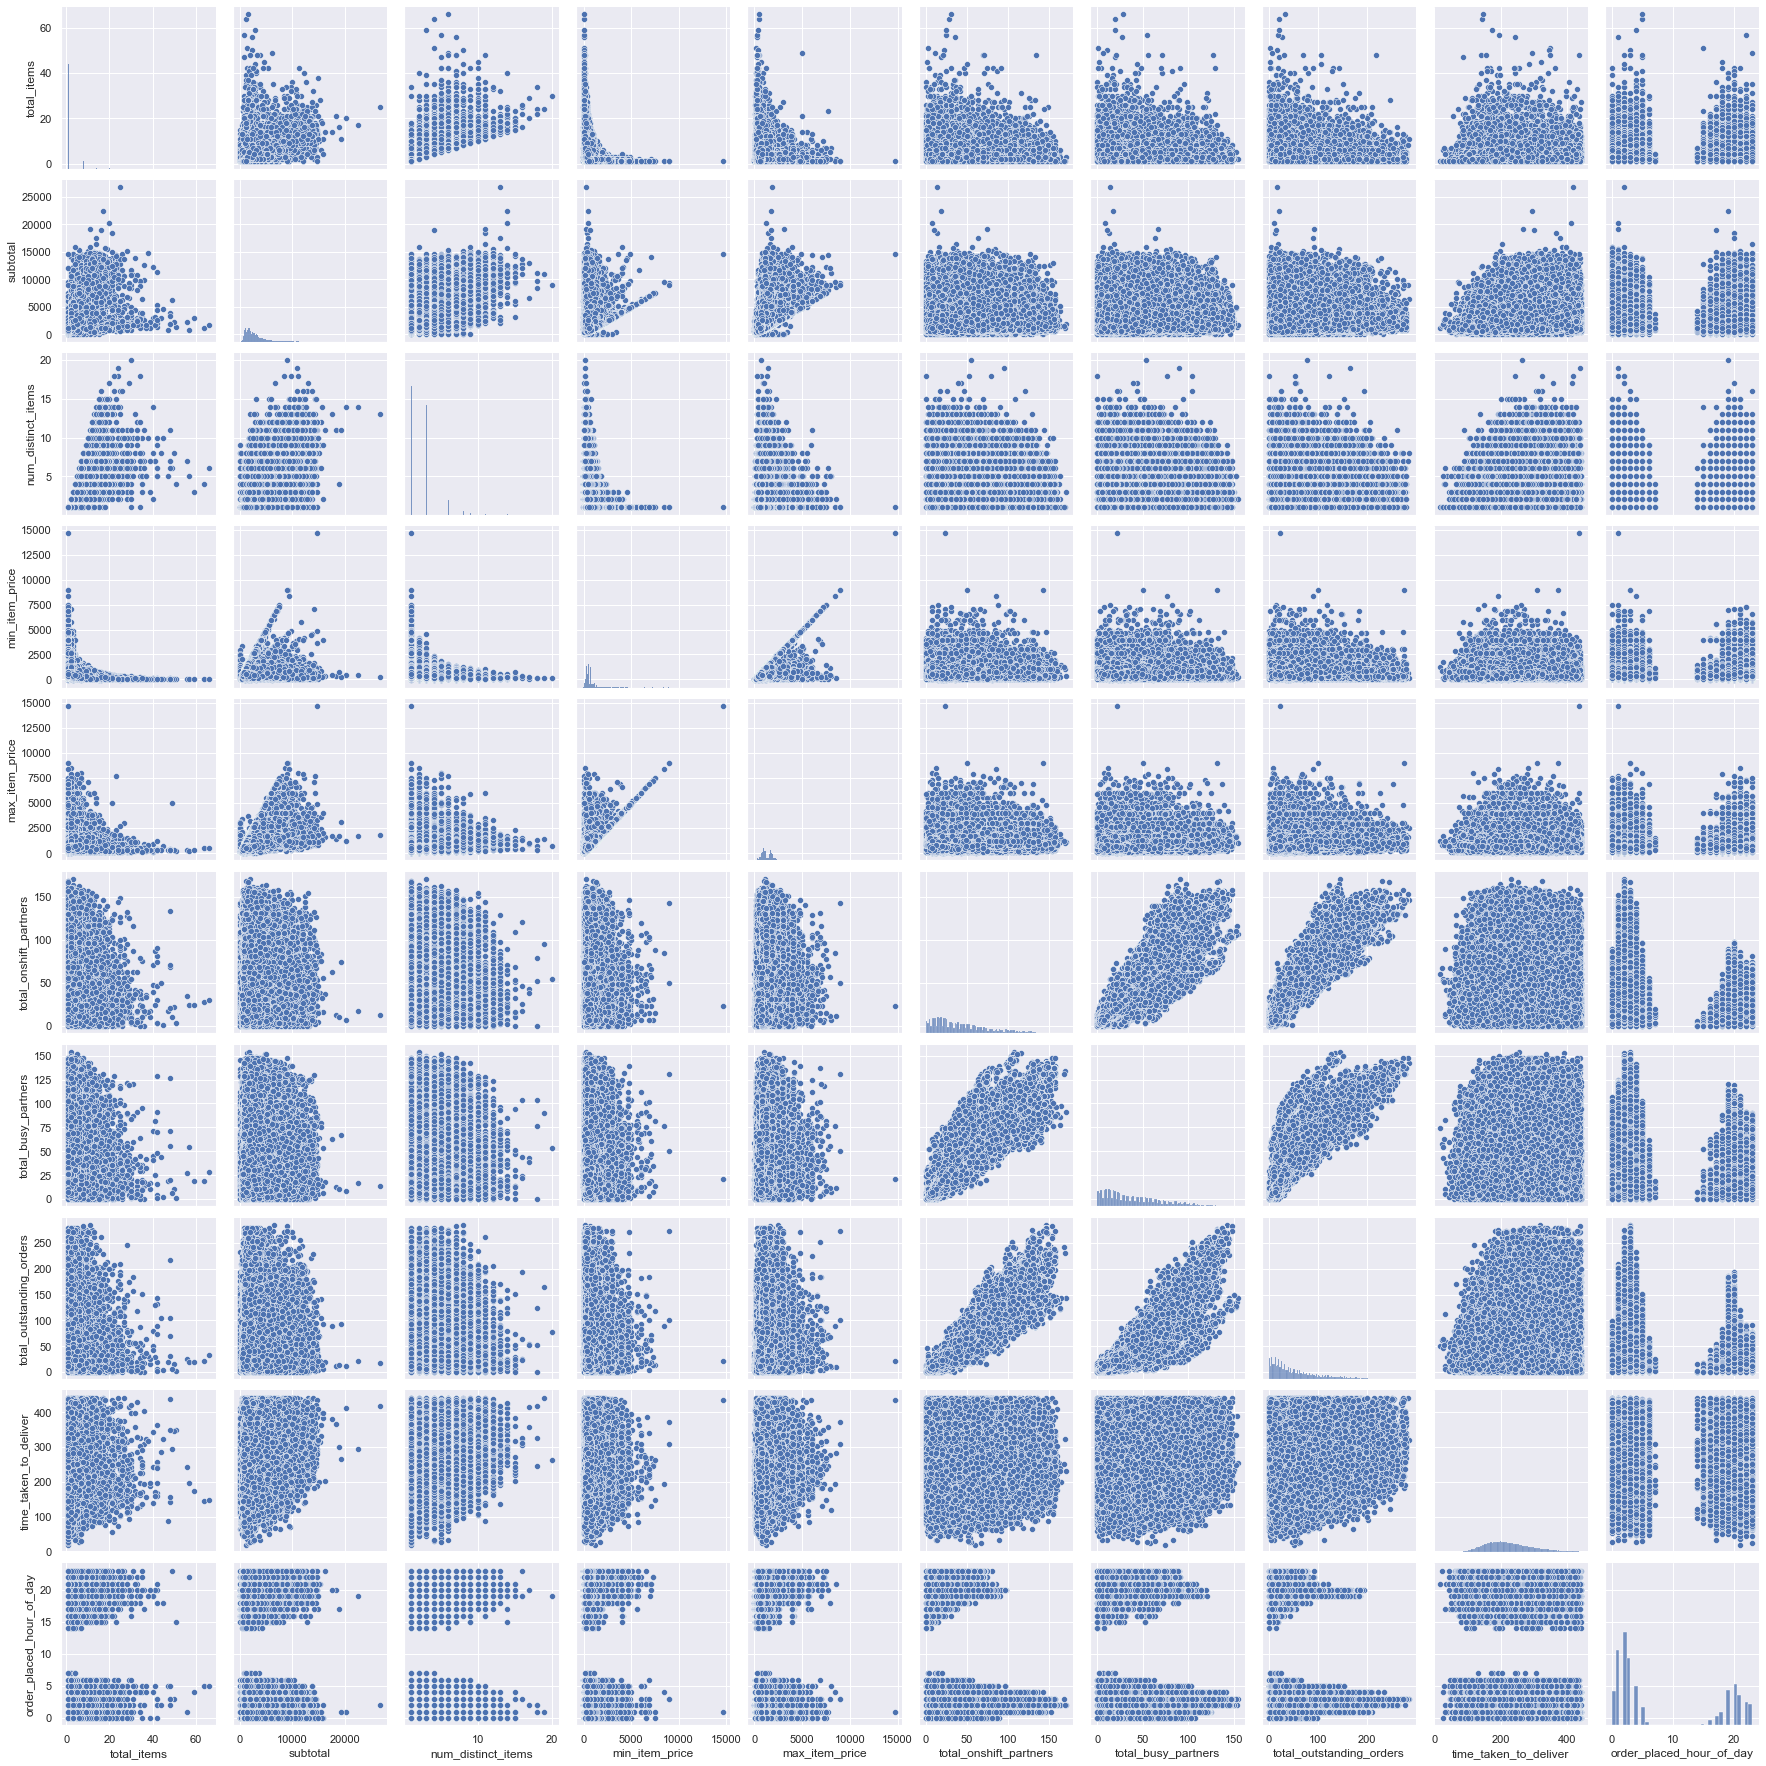

In [35]:
sns.pairplot(df);

***
***
### **Train Test Split**

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['time_taken_to_deliver'], axis=1), df['time_taken_to_deliver'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)

***
***
### **Training and Applying Imputers and Scalers on Train Data**

In [37]:
store_primary_category_imputer = SimpleImputer(strategy='constant', fill_value='other')
X_train['store_primary_category'] = store_primary_category_imputer.fit_transform(X_train[['store_primary_category']])
market_id_imputer = SimpleImputer(strategy='most_frequent')
X_train['market_id'] = market_id_imputer.fit_transform(X_train[['market_id']])
order_protocol_imputer = SimpleImputer(strategy='most_frequent')
X_train['order_protocol'] = order_protocol_imputer.fit_transform(X_train[['order_protocol']])
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)
X_train_columns=X_train.columns
X_train_std=standardscaler.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

In [38]:
X_train.head()

market_id  store_id  store_primary_category  order_protocol  total_items  \
0   0.933918  1.033645                0.586456       -0.590644     1.128151   
1  -0.574871  0.349168               -0.074803        0.069460     0.726301   
2  -1.329266 -0.855855               -1.388066       -1.250748    -0.479248   
3   0.179524 -1.067388                0.095934        1.389667    -0.479248   
4   1.688313  0.366898                1.289310       -1.250748    -0.479248   

   subtotal  num_distinct_items  min_item_price  max_item_price  \
0  1.615773            2.070386       -0.882126       -0.288471   
1  1.505154            0.828543        0.607053        0.078042   
2 -0.906343           -0.413301       -0.497822       -1.262860   
3 -0.763644           -1.034222       -0.067401       -0.907074   
4  0.343653           -1.034222        1.808004        0.837887   

   total_onshift_partners  total_busy_partners  total_outstanding_orders  \
0                1.913767             1.621808                  1.601686   
1                1.072850             0.812673                  0.782179   
2                0.086946             0.252502                  0.057965   
3                0.753881             1.590688                  0.096081   
4               -0.174028            -0.214307                 -0.075443   

   order_placed_day_of_week  order_placed_hour_of_day  
0                 -1.138048                 -0.754651  
1                 -1.138048                 -0.639857  
2                 -1.388469                 -0.754651  
3                 -0.556664                 -0.525063  
4                 -1.138048                 -0.754651

***
***
### **Applying trained Imputers and Scalers on Test and Validation Data**

In [39]:
X_test['store_primary_category'] = store_primary_category_imputer.transform(X_test[['store_primary_category']])
X_test['market_id'] = market_id_imputer.transform(X_test[['market_id']])
X_test['order_protocol'] = order_protocol_imputer.transform(X_test[['order_protocol']])
X_test = target_encoder.transform(X_test)
X_test_columns=X_test.columns
X_test_std=standardscaler.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)

In [40]:
X_val['store_primary_category'] = store_primary_category_imputer.transform(X_val[['store_primary_category']])
X_val['market_id'] = market_id_imputer.transform(X_val[['market_id']])
X_val['order_protocol'] = order_protocol_imputer.transform(X_val[['order_protocol']])
X_val = target_encoder.transform(X_val)
X_val_columns=X_val.columns
X_val_std=standardscaler.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

***
***
## **9. Baseline Model - Random Forest Regressor**

In [195]:
baseline_model = RandomForestRegressor()

***
***
### **Performing 3-fold Cross Validation**

In [196]:
param_grid = {
    'n_estimators': [10, 20, 50, 100],  # number of trees
    'max_depth': [5, 10, 20, 50, 100],  # max depth of the trees
    'min_samples_split': [20, 50, 100, 500],  # minimum samples to split a node
    'min_samples_leaf': [5, 10, 20, 50]  # minimum samples at each leaf node
}
random_search = RandomizedSearchCV(estimator=baseline_model, param_distributions=param_grid, cv=3, n_iter=50, verbose=3)
random_search.fit(X_train, y_train)

In [197]:
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 20}
Best score found:  0.35417744102052345


***
***
### **Training Baseline Model on the Best Parameters found.**

In [198]:
baseline_model = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'],
                                       min_samples_split=random_search.best_params_['min_samples_split'],
                                       min_samples_leaf=random_search.best_params_['min_samples_leaf'],
                                       max_depth=random_search.best_params_['max_depth'])

In [199]:
baseline_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=20)

***
***
### **Performance Metrics of the Baseline Model.**

In [200]:
y_pred = baseline_model.predict(X_test)
rmse = np.sqrt(mse(y_test, y_pred))
mape = np.mean(np.abs(y_test - y_pred) / y_test)
smape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test + y_pred)/2)

print("RMSE:", rmse)
print("MAPE:", mape)
print("sMAPE:", smape)

RMSE: 61.336518964823334
MAPE: 0.23297142813751467
sMAPE: 0.05362661015917341


***
***
## **10. Neural Network Model**

In [255]:
model = Sequential([
      Dense(128, activation="relu", input_shape=(X_train.shape[1],),
            kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden1'),
      Dense(64, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden2'),
      Dense(32, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden3'),
      Dense(16, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden4'),
      Dense(1, activation="linear", name='out')
])

In [256]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "MeanSquaredError",
    metrics = ['RootMeanSquaredError']
)

In [ ]:
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=2)

***
***
### **Performance Metrics of the Neural Network Model.**

In [258]:
model.evaluate(X_test, y_test);

1097/1097 [==============================] - 2s 2ms/step - loss: 3881.0461 - root_mean_squared_error: 62.2980


***
***
### **Saving Baseline and Neural Network Models to the Local Disk.**

In [259]:
import pickle
pickle.dump(baseline_model, open('baseline_model.pkl', 'wb'))
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://2a55d1c5-c7d9-4898-9ce8-979038f00314/assets


INFO:tensorflow:Assets written to: ram://2a55d1c5-c7d9-4898-9ce8-979038f00314/assets


***
***
### **Training the Neural Networks Model again with Dropouts to Improve Performance.**

In [282]:
model = Sequential([
      Dense(128, activation="relu", input_shape=(X_train.shape[1],),
            kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden1'),
      Dropout(0.1),
      Dense(64, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden2'),
      Dropout(0.1),
      Dense(32, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden3'),
      Dropout(0.1),
      Dense(16, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden4'),
      Dropout(0.1),
      Dense(1, activation="linear", name='out')
])

In [285]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.004),
    loss = "MeanSquaredError",
    metrics = ['RootMeanSquaredError']
)

In [ ]:
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=2)

***
***
### **Performance Metrics of the Neural Network Model trained with Dropouts.**

In [287]:
model.evaluate(X_test, y_test);

1097/1097 [==============================] - 2s 1ms/step - loss: 3752.4937 - root_mean_squared_error: 61.2576


***
***
### **Training the Neural Networks Model again with Dropouts and Batch Normalization to Improve Performance further.**

In [66]:
model = Sequential([
      Dense(128, activation="relu", input_shape=(X_train.shape[1],),
            kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden1'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(64, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden2'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(32, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden3'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(16, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden4'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(1, activation="linear", name='out')
])

In [67]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = "MeanSquaredError",
    metrics = ['RootMeanSquaredError']
)

In [ ]:
model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=2);

***
***
### **Performance Metrics of the Neural Network Model trained with Dropouts and Batch Normalization.**

In [69]:
model.evaluate(X_test, y_test);

1097/1097 [==============================] - 2s 2ms/step - loss: 3679.5132 - root_mean_squared_error: 60.6590


***
***
### **Root Mean Squared Error is around 81% of the Standard Deviation in Actual Delivery Times.**

In [71]:
60.6590/np.std(y_train)

0.8193300236977832

***
***
### **Mean Absolute Error is around 47 Minutes and is around 67% of the Standard Deviation (74 Minutes) in Actual Delivery Times.**

In [75]:
y_pred = model.predict(X_test)

1097/1097 [==============================] - 6s 2ms/step


In [84]:
np.mean(np.abs(np.array(y_test) - y_pred[:,0]))

47.43322661621831

In [190]:
47.43322661621831/np.std(y_train)

0.67336132455388

***
***
### **Mean and Median of Actual Delivery Times are around 220 Minutes 210 Minutes respectively.**

In [213]:
y_test.describe()

count    28190.000000
mean       220.657189
std         70.287447
min         18.580000
25%        168.750000
50%        210.750000
75%        263.580000
max        423.330000
Name: time_taken_to_deliver, dtype: float64

***
***
### **Mean and Median of Predicted Delivery Times are around 221 Minutes 216 Minutes respectively.**

In [212]:
pd.Series(y_pred[:,0]).describe()

count    28190.000000
mean       221.670288
std         41.664570
min         98.065948
25%        192.385731
50%        216.163048
75%        246.864731
max        448.707825
dtype: float64

***
***
### **Training the Neural Networks Model again with Outlier Removal using IQR Method for All Columns to Improve Performance further.**

In [115]:
filename = 'dataset.csv'
df = pd.read_csv(filename)
df = df.drop(df[df.actual_delivery_time.isna()].index)
df = df.drop(df[df.total_onshift_partners < 0].index)
df = df.drop(df[df.total_busy_partners < 0].index)
df = df.drop(df[df.total_outstanding_orders < 0].index)
df = df.drop(df[df.total_onshift_partners.isna()].index)
df = df.drop(df[df.total_busy_partners.isna()].index)
df = df.drop(df[df.total_outstanding_orders.isna()].index)
df = df[df.total_items<411]
df = convert_to_best_type(df)
df['time_taken_to_deliver'] = np.round((df.actual_delivery_time-df.created_at).dt.total_seconds()/12, 2)
df['order_placed_day_of_week'] = df.created_at.dt.dayofweek
df['order_placed_hour_of_day'] = df.created_at.dt.hour
df = df.drop(['actual_delivery_time', 'created_at'], axis=1)
df = convert_to_best_type(df)
for column in get_columns_by_types(df, ['string']):
    df[column] = pd.Categorical(df[column])

***
***
### **Outlier Removal.**

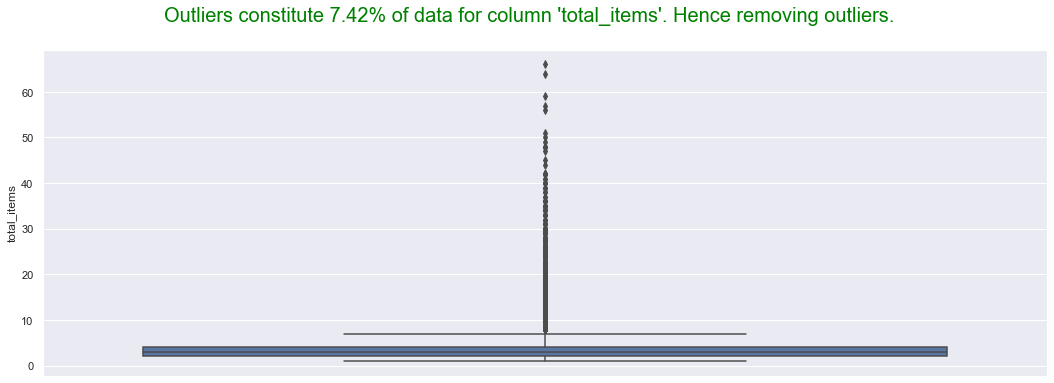

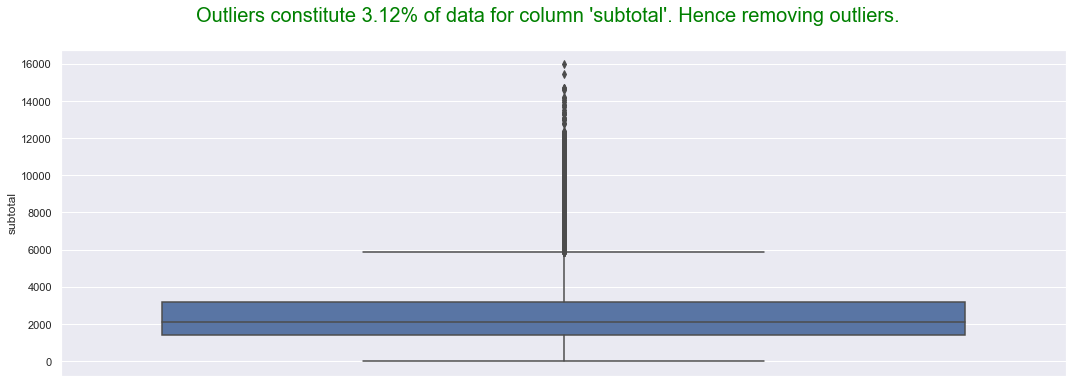

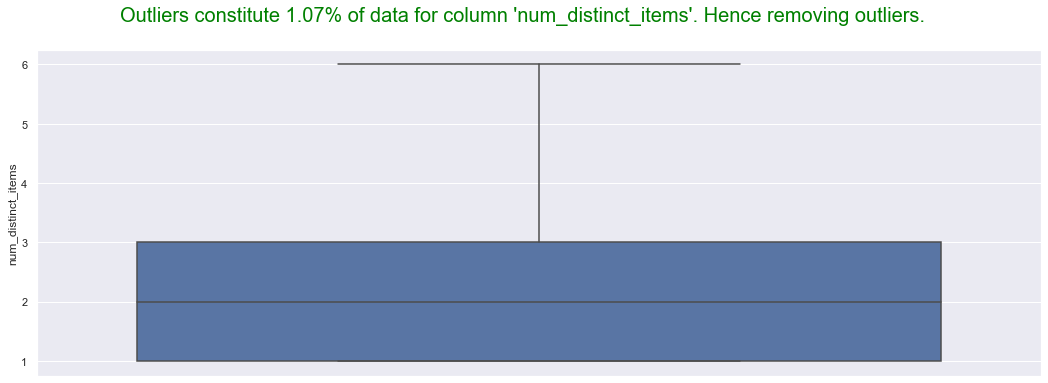

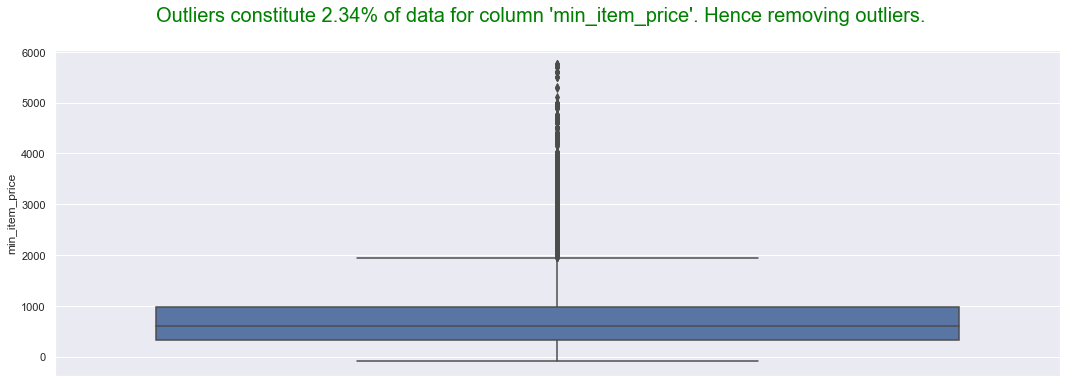

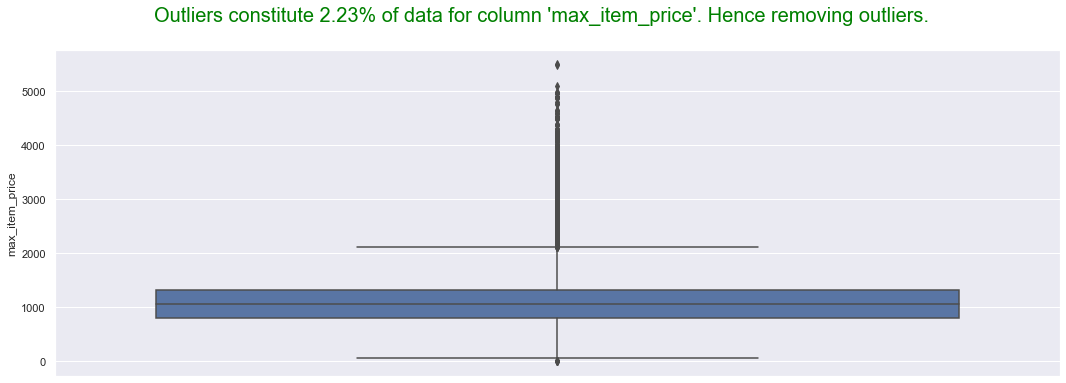

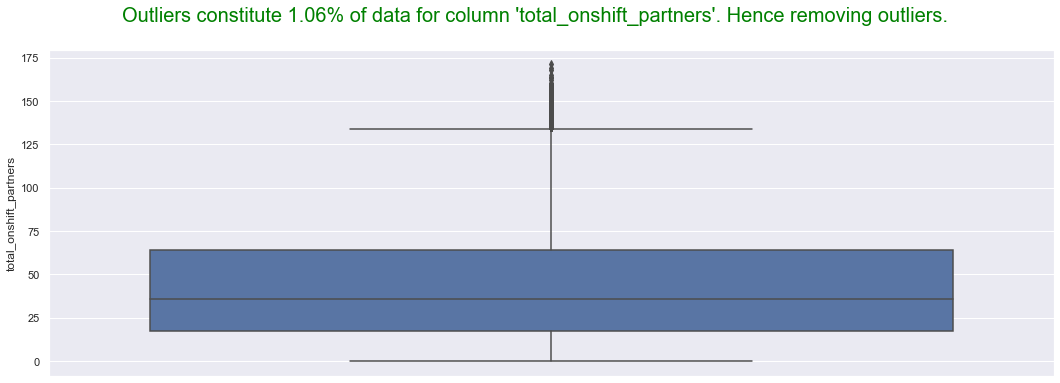

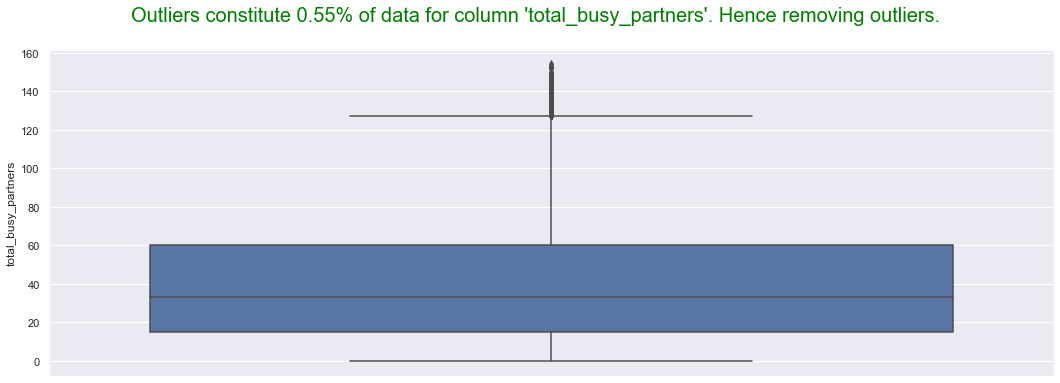

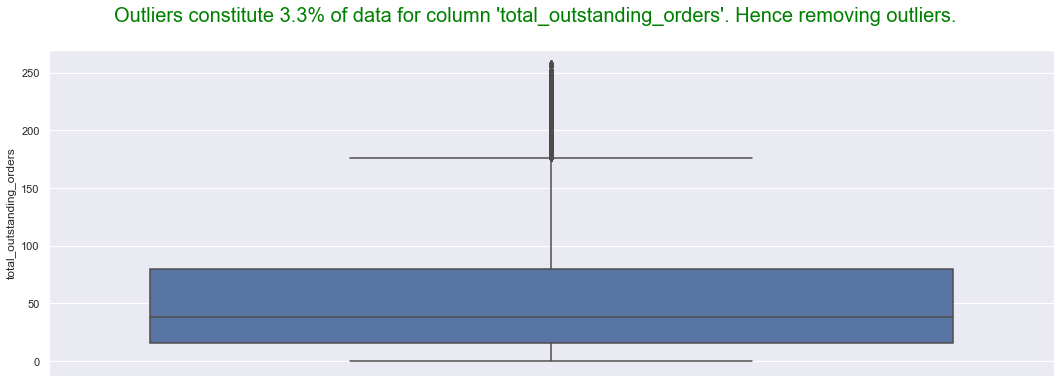

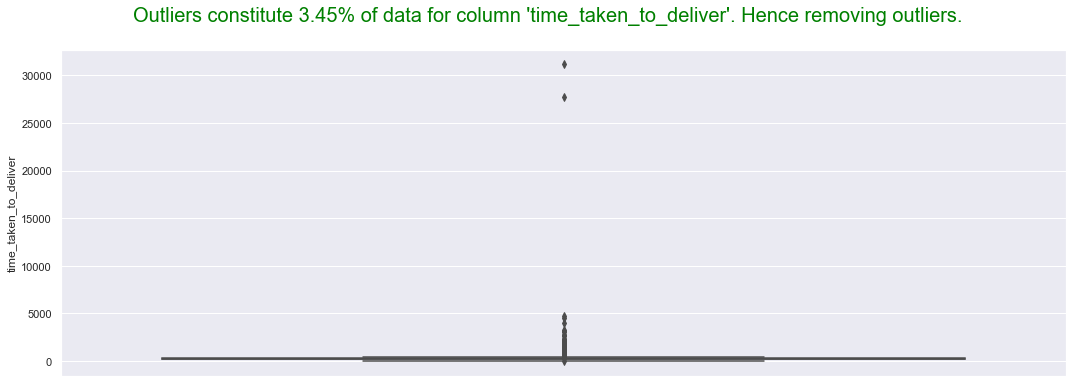

In [116]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column, thresh=10)

***
***
### **Train-Test Split, Imputation and Scaling.**

In [117]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['time_taken_to_deliver'], axis=1), df['time_taken_to_deliver'], random_state=0, test_size = .2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size = .2)

store_primary_category_imputer = SimpleImputer(strategy='constant', fill_value='other')
X_train['store_primary_category'] = store_primary_category_imputer.fit_transform(X_train[['store_primary_category']])
market_id_imputer = SimpleImputer(strategy='most_frequent')
X_train['market_id'] = market_id_imputer.fit_transform(X_train[['market_id']])
order_protocol_imputer = SimpleImputer(strategy='most_frequent')
X_train['order_protocol'] = order_protocol_imputer.fit_transform(X_train[['order_protocol']])
target_encoder = TargetEncoder(return_df=True)
X_train = target_encoder.fit_transform(X_train, y_train)
X_train_columns=X_train.columns
X_train_std=standardscaler.fit_transform(X_train)
X_train=pd.DataFrame(X_train_std, columns=X_train_columns)

X_test['store_primary_category'] = store_primary_category_imputer.transform(X_test[['store_primary_category']])
X_test['market_id'] = market_id_imputer.transform(X_test[['market_id']])
X_test['order_protocol'] = order_protocol_imputer.transform(X_test[['order_protocol']])
X_test = target_encoder.transform(X_test)
X_test_columns=X_test.columns
X_test_std=standardscaler.transform(X_test)
X_test=pd.DataFrame(X_test_std, columns=X_test_columns)

X_val['store_primary_category'] = store_primary_category_imputer.transform(X_val[['store_primary_category']])
X_val['market_id'] = market_id_imputer.transform(X_val[['market_id']])
X_val['order_protocol'] = order_protocol_imputer.transform(X_val[['order_protocol']])
X_val = target_encoder.transform(X_val)
X_val_columns=X_val.columns
X_val_std=standardscaler.transform(X_val)
X_val=pd.DataFrame(X_val_std, columns=X_val_columns)

***
***
### **Model Training.**

In [182]:
model = Sequential([
      Dense(128, activation="relu", input_shape=(X_train.shape[1],),
            kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden1'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(64, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden2'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(32, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden3'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(16, activation="relu", kernel_initializer='glorot_uniform', bias_initializer="zeros", name='Hidden4'),
      BatchNormalization(),
      Dropout(0.1),
      Dense(1, activation="linear", name='out')
])

In [183]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05),
    loss = "MeanSquaredError",
    metrics = ['RootMeanSquaredError']
)

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), verbose=2);

***
***
### **Performance Metrics.**

In [121]:
model.evaluate(X_test, y_test);

881/881 [==============================] - 1s 1ms/step - loss: 3663.8542 - root_mean_squared_error: 60.5298


In [123]:
y_pred = model.predict(X_test)

881/881 [==============================] - 5s 2ms/step


In [124]:
np.mean(np.abs(np.array(y_test) - y_pred[:,0]))

47.57600196601838

***
***
### **Train vs Validation Loss.**

In [185]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

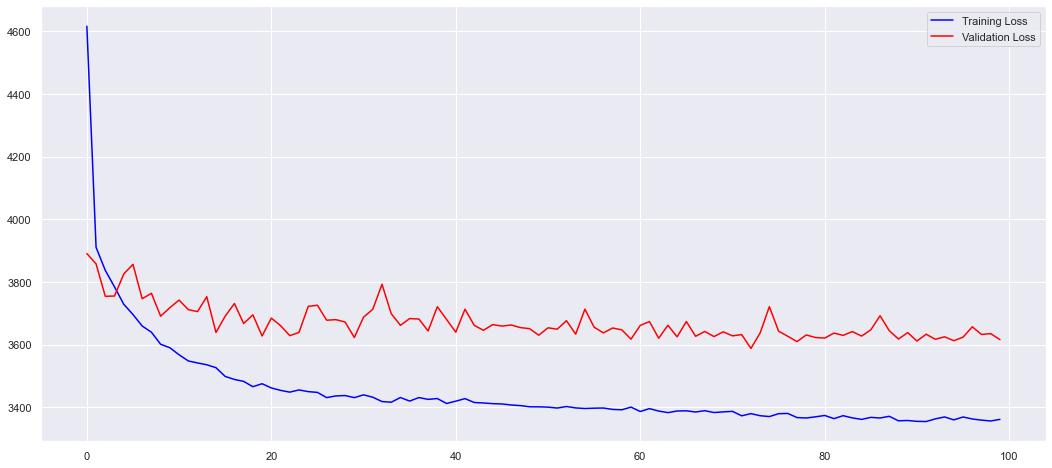

In [187]:
fig, axes = plt.subplots(figsize=(18,8))
sns.lineplot(range(len(train_loss)), train_loss, color='blue', label='Training Loss')
sns.lineplot(range(len(val_loss)), val_loss, color='red', label='Validation Loss')
plt.legend()
plt.show()

***
***
## **11. Model Comparison**
### NN Model is performing slightly better than RF regressor, with RMSE of 60 minutes and MAE of 47 minutes.

***
***
***
## **12. Leading Questions**
***
***
### **1. Defining the problem statements and where can this and modifications of this be used?**
### **Ans:** The primary problem statement for this project is to build a model that can accurately estimate the delivery time for Porter, based on various factors such as order details and availability of delivery partners. This model can significantly enhance customer experience by providing accurate delivery estimates. A modification of this problem could be to predict the earnings of a delivery partner based on factors like number of deliveries, distance covered, etc. This could be used by the company to optimize their resource allocation and by delivery partners to maximize their earnings.

***
***
### **2. List 3 functions the pandas datetime provides with one line explanation.**
### **Ans:** 
#### **to_datetime()**: Converts a string, integer, or float date to a datetime format.
#### **date_range()**: Generates a sequence of equally spaced dates within a specified range.
#### **Timedelta()**: Allows for operations involving differences in time.

***
***
### **3. Short note on datetime, timedelta, time span (period).**
### **Ans:** 
#### **datetime**: This represents a single point in time. It includes both a date and a time.
#### **timedelta**: This represents a duration or difference between two dates or times.
#### **period**: This represents an interval or span of time. It can be a span of any length (e.g., a day, a month, a quarter, etc.).

***
***
### **4. Why do we need to check for outliers in our data?**
### **Ans:** Outliers can significantly impact the results of a machine learning model. They can skew the model's interpretation of the data, leading to inaccurate predictions. Identifying and handling outliers is an important step in the data cleaning process to ensure the robustness of the model.

***
***
### **5. Name 3 outlier removal methods?**
### **Ans:** 
#### **Z-score method**: Outliers are identified as data points that are too many standard deviations away from the mean.
#### **Interquartile Range (IQR) method**: Outliers are identified as data points that fall below the first quartile or above the third quartile by a certain factor of the IQR.
#### **Isolation Forest**: This is a machine learning algorithm that is specifically designed for outlier detection.

***
***
### **6. What classical machine learning methods can we use other than random forest for regression?**
### **Ans:** Besides Random Forest, we can use Linear Regression, Support Vector Regression, Decision Trees, Gradient Boosting, and Ridge/Lasso Regression for this task.

***
***
### **7. Why is scaling required for neural networks?**
### **Ans:** Scaling is important for neural networks because it ensures all input features are on a similar scale, which allows the gradient descent process to converge more quickly and efficiently. Without scaling, features with larger scales can dominate the learning process, leading to sub-optimal results.

***
***
### **8. Briefly explain your choice of optimizer.**
### **Ans:** I utilized the Adam optimizer for training the neural network model due to its advantageous properties for handling large and potentially noisy datasets. Adam, an acronym for Adaptive Moment Estimation, is an optimization algorithm that calculates adaptive learning rates for each parameter, effectively combining the strengths of two Stochastic Gradient Descent extensions: Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad). This makes it particularly effective for this project, given the potential noise in the data. Additionally, Adam requires less memory compared to other optimization algorithms, which is beneficial for large datasets, and its default configuration often works well, thus minimizing the need for extensive hyperparameter tuning.

***
***
### **9. Which activation function did you use and why?**
### **Ans:** I used the Rectified Linear Unit (ReLU) activation function in the hidden layers of the neural network, as it effectively handles the vanishing gradient problem common in deep learning. For the output layer, a linear activation function was used, suitable for the regression task at hand as it allows for a continuous range of output values.

***
***
### **10. Why does a neural network perform well on a large dataset?**
### **Ans:** Neural networks have the ability to learn complex patterns and relationships in data, but this requires a large amount of data to avoid overfitting and to generalize well. With larger datasets, neural networks have more examples from which to learn, which can result in more accurate and robust models.